## Deep Learning Course Project - Gesture Recognition

### Problem Statement
Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:
 
| Gesture | Corresponding Action |
| --- | --- | 
| Thumbs Up | Increase the volume. |
| Thumbs Down | Decrease the volume. |
| Left Swipe | 'Jump' backwards 10 seconds. |
| Right Swipe | 'Jump' forward 10 seconds. |
| Stop | Pause the movie. |

Each video is a sequence of 30 frames (or images).

### Objectives:
1. **Generator**:  The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

2. **Model**: Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. As suggested by Snehansu, start training on a small amount of data and then proceed further.

3. **Write up**: This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model. 


In [1]:
## Checking the GPU configuration

!nvidia-smi

Tue Apr 16 23:07:07 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.06              Driver Version: 545.23.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090 ...    On  | 00000000:01:00.0 Off |                  N/A |
| N/A   53C    P5              22W /  80W |    103MiB / 16376MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Libraries preparion

In [1]:
# Importing the necessary libraries

import numpy as np
import os
#from scipy.misc import imread, imresize
import cv2
from skimage.transform import resize

import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import abc
from sys import getsizeof
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')



In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
#tf.set_random_seed(30)
tf.random.set_seed(30)



2024-04-16 23:14:43.122938: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-16 23:14:43.155864: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-16 23:14:43.666550: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# importing some other libraries which will be needed for model building.

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, LSTM, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard, CSVLogger
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
import datetime
import time

In [4]:
%load_ext tensorboard

In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


2024-04-16 23:14:44.375228: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 23:14:44.401360: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 23:14:44.403110: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [6]:
project_folder='../Gesture-Recognition-Using-Conv3D-and-transfer-learning-Convolutional-RNN-architecture/Project_data'

### Plot function

In [7]:
# function to plot the training/validation accuracies/losses.

def plot(history, model):
    print(history.history.keys())
    # display first epoch of training accuracy, validation accuracy, training loss, validation loss
    print(history.history['categorical_accuracy'][0], history.history['val_categorical_accuracy'][0], history.history['loss'][0], history.history['val_loss'][0])
    # display max validation accuracy epoch of training accuracy, training loss, validation accuracy, validation loss and number of the best epoch
    print(max(history.history['categorical_accuracy']), history.history['loss'][np.argmax(history.history['val_categorical_accuracy'])], max(history.history['val_categorical_accuracy']), history.history['val_loss'][np.argmax(history.history['val_categorical_accuracy'])], np.argmax(history.history['val_categorical_accuracy']))
    
    # save the first epoch values and best epoch in a csv file order: epoch,train_acc,train_loss,val_acc,val_loss
    if model:      
        path = '/'.join(model.filepath.split('/')[:-1]) + '/'
        with open(path + 'first_best_values.csv', 'w') as f:
            f.write('epoch,train_acc,train_loss,val_acc,val_loss\n')
            f.write('0,' + str(history.history['categorical_accuracy'][0])  + "," + 
                    str(history.history['val_categorical_accuracy'][0]) + "," + 
                    str(history.history['loss'][0]) + "," + 
                    str(history.history['val_loss'][0]) + 
                    '\n')
            f.write(str(np.argmax(history.history['val_categorical_accuracy'])) + ',' +
                    str(history.history['categorical_accuracy'][np.argmax(history.history['val_categorical_accuracy'])]) + ',' +
                    str(history.history['loss'][np.argmax(history.history['val_categorical_accuracy'])]) + ',' +
                    str(max(history.history['val_categorical_accuracy'])) + ',' +
                    str(history.history['val_loss'][np.argmax(history.history['val_categorical_accuracy'])]) + 
                    '\n')

    
    # Accuracy

    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Test'], loc = 'upper left')
    if model:
        plt.savefig(path + 'accuracy.png')
    plt.show()

    # Loss

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Test'], loc = 'upper left')
    if model:
        plt.savefig(path + 'loss.png')
    plt.show()

In [8]:
# Record the model classname, model hyperparameters, number of trainable parameters and the best validation accuracies epoch of best epoch/total epoch, training/validation accuracies and losses in a csv file
def save_summary(model, defined_model, history):
    print(not os.path.exists('model_summary.csv'))
    if not os.path.exists('model_summary.csv'):
        with open('model_summary.csv', '+w') as f:
            f.write('Model Name, frames_to_sample, batch size, #epoch, input size, # Trainable Parameters, time, Best Validation Epoch, Training Accuracies, Training Losses, Validation Accuracies, Validation Losses, variables\n')
 

    with open('model_summary.csv', 'a') as f:        
        f.write(model.name + ',' + str(model.frames_to_sample) + ',' + 
                str(model.batch_size) + ',' + 
                str(model.num_epochs) + ',' + 
                str(model.image_width) + 'x' + str(model.image_height) + ',' +
                str(defined_model.count_params()) + ',' +
                str(model.total_time) + ',' +
                str(np.argmax(history.history['val_categorical_accuracy'])) + '/' + str(model.num_epochs) + ',' +
                str(history.history['categorical_accuracy'][np.argmax(history.history['val_categorical_accuracy'])]) + ',' +
                str(history.history['loss'][np.argmax(history.history['val_categorical_accuracy'])]) + ',' +
                str(max(history.history['val_categorical_accuracy'])) + ',' +
                str(history.history['val_loss'][np.argmax(history.history['val_categorical_accuracy'])]) + ',' +
                str(defined_model.variables).replace(',',';')+
                '\n')


### Data Augmentation, Data Generator and Model Building

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [9]:
#data resizing - Resizing all the images, so we can have all the images in a specific size

def crop_resize_img(img, rows, cols):
    if img.shape[0] != img.shape[1]:
        img=img[0:120,20:120]
    resized_image = resize(img, (rows,cols))
    return resized_image

In [11]:

class ModelBuilder(metaclass= abc.ABCMeta):
    # initialisng the path where project data resides
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)

    # initialising the image properties    
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
        

    # initialising the batch size, frames to sample and the no. of epochs
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
    # MOST IMPORTANT PART HERE - The generator function        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
   
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx):
                #performing image reading and resizing
                image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                #image_resized=imresize(image,(self.image_height,self.image_width,3))
                image_resized = crop_resize_img(image,self.image_width,self.image_height)
                # image_resized = cv2.resize(image, (self.image_width,self.image_height), interpolation = cv2.INTER_AREA)

                #normalizing the images
                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    # Randomly shifting the image to the left or right
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    # cropping the images to have the targeted gestures and remove the noise from the images.
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    # image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    image_resized = crop_resize_img(cropped, self.image_width, self.image_height)
                    # image_resized = cv2.resize(cropped, (self.image_width,self.image_height), interpolation = cv2.INTER_AREA)

                    M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))

                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        start_time = time.perf_counter()
                
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        if not os.path.exists('model'):
            os.mkdir('model')

        model_name = 'model/' + 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
        self.filepath = filepath

        checkpoint = ModelCheckpoint(filepath + '.keras', monitor='val_loss', verbose=1, save_freq='epoch', save_best_only=True, save_weights_only=False, mode='auto')
        checkpoint_h5 = ModelCheckpoint(filepath + '.weights.h5', monitor='val_loss', verbose=1, save_freq='epoch', save_best_only=True, save_weights_only=True, mode='auto')
        
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)
        earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
        
        logdir = "logs/scalars/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = TensorBoard(log_dir=logdir)
        csv_logger = CSVLogger(f'{filepath}.log')

        callbacks_list = [checkpoint, checkpoint_h5, LR, earlystop, tensorboard_callback, csv_logger]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        # history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
        #                     callbacks=callbacks_list, validation_data=val_generator, 
        #                     validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, initial_epoch=0)
        end_time = time.perf_counter()
        self.total_time = end_time - start_time
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass
    
    

### Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

#### Sample Model


In [12]:

class ModelConv3D1(ModelBuilder):
    
    def define_model(self, name='model_conv3d_1'):
        self.name = name
        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Conv3D(64, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Conv3D(128, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        # optimiser = optimizers.Adam()
        #optimiser = 'sgd'
        optimizer = optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

##### Sample data after augment

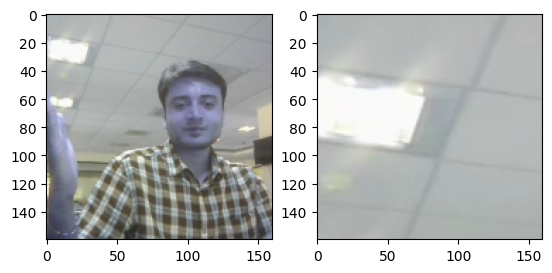

In [13]:
test_generator=ModelConv3D1()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=160,image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,15,:,:,:]) 
axes[1].imshow(batch_data[3,15,:,:,:])

In [14]:
# Experimenting first with the ModelConv3D1 model
# Model 1, frames_to_sample=30, batch_size=20, num_epochs=20, image_height=160, image_width=160

conv_3d1_1=ModelConv3D1()
conv_3d1_1.initialize_path(project_folder)
conv_3d1_1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1_1.initialize_hyperparams(frames_to_sample=30,batch_size=20,num_epochs=20)
conv_3d1_1_model=conv_3d1_1.define_model("conv_3d1_1")
conv_3d1_1_model.summary()

2024-04-15 03:14:14.152651: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-15 03:14:14.154165: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-15 03:14:14.155562: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 30, 160, 160,   │         1,312 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 30, 160, 160,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 160, 160,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 15, 80, 80, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 15, 80, 80, 32) │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 15, 80, 80, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 15, 80, 80, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 7, 40, 40, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 7, 40, 40, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 7, 40, 40, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 40, 40, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 3, 20, 20, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 3, 20, 20, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 3, 20, 20, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 3, 20, 20, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 1, 10, 10, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,940,677 (7.40 MB)

 Trainable params: 1,939,813 (7.40 MB)

 Non-trainable params: 864 (3.38 KB)

In [15]:
# Show the total number of parameters and start the training
print("Total Params:", conv_3d1_1_model.count_params())
history_model1=conv_3d1_1.train_model(conv_3d1_1_model, augment_data=True)

Total Params: 1940677
Epoch 1/20


I0000 00:00:1713122069.831764 3375731 service.cc:145] XLA service 0xa0bdd80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1713122069.831792 3375731 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4090 Laptop GPU, Compute Capability 8.9
2024-04-15 03:14:30.042409: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-15 03:14:30.250400: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2024-04-15 03:14:44.023705: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,16,3,3,3]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[40,16,15,80,80]{4,3,2,1,0}, f32[40,32,15,80,80]{4,3,2,1,0}), window={size=3x3x3 pad=1_1x1_1x1_1}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id"

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - categorical_accuracy: 0.2951 - loss: 1.9316
Epoch 1: val_loss improved from inf to 96.11609, saving model to model/model_init_2024-04-1503_14_14.867086/model-00001-1.79901-0.32428-96.11609-0.23000.h5.keras

Epoch 1: val_loss improved from inf to 96.11609, saving model to model/model_init_2024-04-1503_14_14.867086/model-00001-1.79901-0.32428-96.11609-0.23000.h5.weights.h5
34/34 ━━━━━━━━━━━━━━━━━━━━ 236s 7s/step - categorical_accuracy: 0.2959 - loss: 1.9278 - val_categorical_accuracy: 0.2300 - val_loss: 96.1161 - learning_rate: 0.0100
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - categorical_accuracy: 0.3846 - loss: 1.4746
Epoch 2: val_loss improved from 96.11609 to 23.74822, saving model to model/model_init_2024-04-1503_14_14.867086/model-00002-1.48550-0.38839-23.74822-0.23000.h5.keras

Epoch 2: val_loss improved from 96.11609 to 23.74822, saving model to model/model_init_2024-04-1503_14_14.867086/model-00002-1.48550-0.38839-23.74822-0.23000.

dict_keys(['categorical_accuracy', 'loss', 'val_categorical_accuracy', 'val_loss', 'learning_rate'])
0.32428357005119324 0.23000000417232513 1.7990148067474365 96.1160888671875
0.7285068035125732 0.732304036617279 0.6800000071525574 0.871707558631897 19


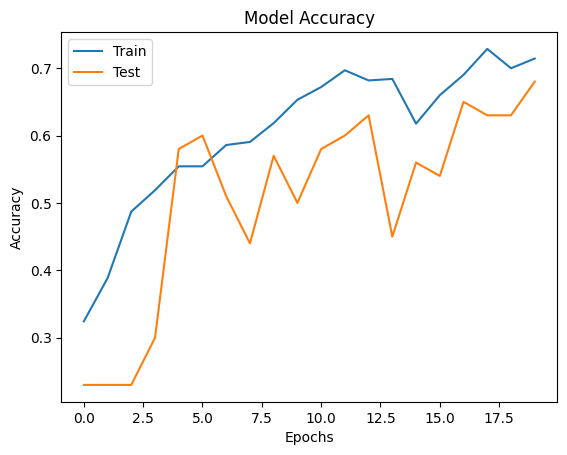

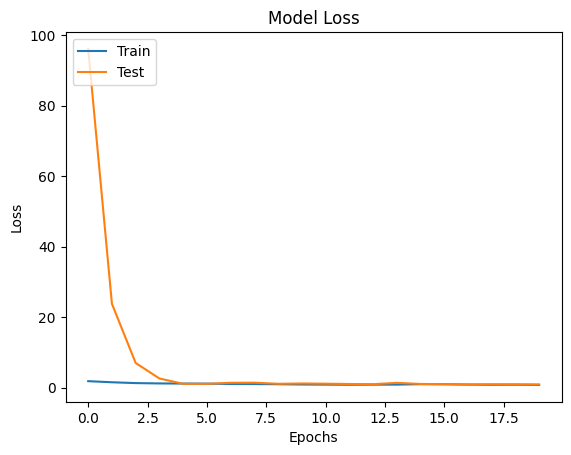

True


In [16]:
# Plot the training/validation accuracies/losses
plot(conv_3d1_1_model.history, conv_3d1_1.filepath)
# Save the model summary
save_summary(conv_3d1_1, conv_3d1_1_model, history_model1)


In [17]:
# Experimenting with different hyperparameters
# Model 2, frames_to_sample=30, batch_size=30, num_epochs=20, image_height=160, image_width=160
conv_3d1_2=ModelConv3D1()
conv_3d1_2.initialize_path(project_folder)
conv_3d1_2.initialize_image_properties(image_height=160,image_width=160)
conv_3d1_2.initialize_hyperparams(frames_to_sample=30,batch_size=30,num_epochs=20)
conv_3d1_2_model=conv_3d1_2.define_model("conv_3d1_2")
print("Total Params:", conv_3d1_2_model.count_params())
conv_3d1_2_model.summary()

Total Params: 1940677


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_4 (Conv3D)               │ (None, 30, 160, 160,   │         1,312 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 30, 160, 160,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 30, 160, 160,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_4 (MaxPooling3D)  │ (None, 15, 80, 80, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_5 (Conv3D)               │ (None, 15, 80, 80, 32) │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 15, 80, 80, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 15, 80, 80, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_5 (MaxPooling3D)  │ (None, 7, 40, 40, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_6 (Conv3D)               │ (None, 7, 40, 40, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 7, 40, 40, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 7, 40, 40, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_6 (MaxPooling3D)  │ (None, 3, 20, 20, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_7 (Conv3D)               │ (None, 3, 20, 20, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 3, 20, 20, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 3, 20, 20, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_7 (MaxPooling3D)  │ (None, 1, 10, 10, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,940,677 (7.40 MB)

 Trainable params: 1,939,813 (7.40 MB)

 Non-trainable params: 864 (3.38 KB)

In [18]:
# Show the total number of parameters and start the training
print("Total Params:", conv_3d1_2_model.count_params())
history_model2=conv_3d1_2.train_model(conv_3d1_2_model, augment_data=True)


Total Params: 1940677
Epoch 1/20


2024-04-15 04:21:28.562160: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[16,3,3,3,3]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[60,3,30,160,160]{4,3,2,1,0}, f32[60,16,30,160,160]{4,3,2,1,0}), window={size=3x3x3 pad=1_1x1_1x1_1}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-04-15 04:21:28.717469: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.155476087s
Trying algorithm eng0{} for conv (f32[16,3,3,3,3]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[60,3,30,160,160]{4,3,2,1,0}, f32[60,16,30,160,160]{4,3,2,1,0}), window={size=3x3x3 pad=1_1x1_1x1_1}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - categorical_accuracy: 0.2893 - loss: 1.9610
Epoch 1: val_loss improved from inf to 148.98727, saving model to model/model_init_2024-04-1504_20_54.911664/model-00001-1.78777-0.31976-148.98727-0.23000.h5.keras

Epoch 1: val_loss improved from inf to 148.98727, saving model to model/model_init_2024-04-1504_20_54.911664/model-00001-1.78777-0.31976-148.98727-0.23000.h5.weights.h5
23/23 ━━━━━━━━━━━━━━━━━━━━ 227s 9s/step - categorical_accuracy: 0.2906 - loss: 1.9537 - val_categorical_accuracy: 0.2300 - val_loss: 148.9873 - learning_rate: 0.0100
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - categorical_accuracy: 0.4511 - loss: 1.3955
Epoch 2: val_loss improved from 148.98727 to 51.85409, saving model to model/model_init_2024-04-1504_20_54.911664/model-00002-1.45267-0.44268-51.85409-0.23000.h5.keras

Epoch 2: val_loss improved from 148.98727 to 51.85409, saving model to model/model_init_2024-04-1504_20_54.911664/model-00002-1.45267-0.44268-51.85409-0

dict_keys(['categorical_accuracy', 'loss', 'val_categorical_accuracy', 'val_loss', 'learning_rate'])
0.31975868344306946 0.23000000417232513 1.787768006324768 148.98727416992188
0.7239819169044495 0.8343355059623718 0.6399999856948853 0.9899168014526367 14


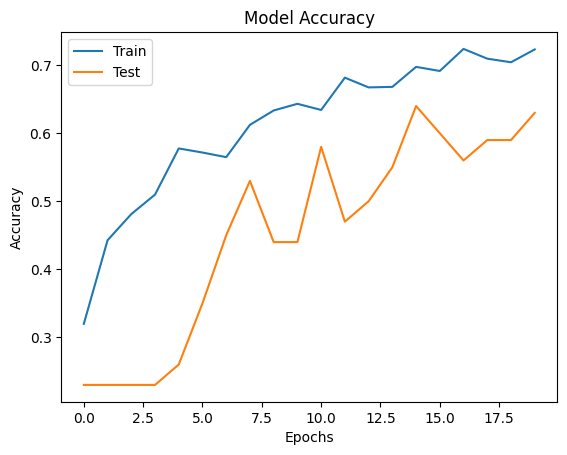

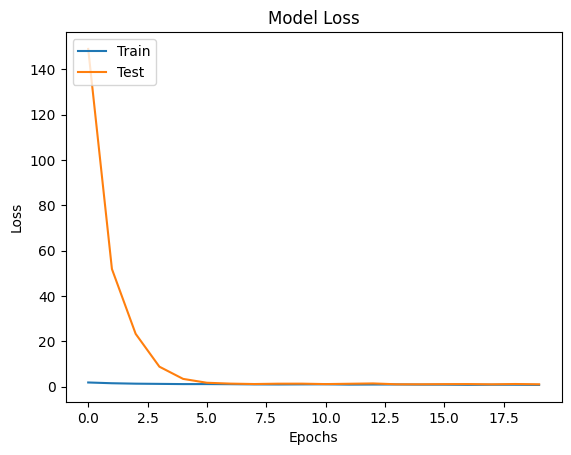

False


In [19]:
# Plot the training/validation accuracies/losses
plot(conv_3d1_2_model.history, conv_3d1_2.filepath)

# Save the model summary
save_summary(conv_3d1_2, conv_3d1_2_model, history_model2)

In [20]:
# Experimenting with different hyperparameters
# Model 3, frames_to_sample=30, batch_size=40, num_epochs=20, image_height=160, image_width=160
conv_3d1_3=ModelConv3D1()
conv_3d1_3.initialize_path(project_folder)
conv_3d1_3.initialize_image_properties(image_height=160,image_width=160)
conv_3d1_3.initialize_hyperparams(frames_to_sample=30,batch_size=40,num_epochs=20)
conv_3d1_3_model=conv_3d1_3.define_model("conv_3d1_3")
print("Total Params:", conv_3d1_3_model.count_params())
conv_3d1_3_model.summary()

Total Params: 1940677


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_8 (Conv3D)               │ (None, 30, 160, 160,   │         1,312 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 30, 160, 160,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 30, 160, 160,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_8 (MaxPooling3D)  │ (None, 15, 80, 80, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_9 (Conv3D)               │ (None, 15, 80, 80, 32) │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 15, 80, 80, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 15, 80, 80, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_9 (MaxPooling3D)  │ (None, 7, 40, 40, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_10 (Conv3D)              │ (None, 7, 40, 40, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 7, 40, 40, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 7, 40, 40, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_10 (MaxPooling3D) │ (None, 3, 20, 20, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_11 (Conv3D)              │ (None, 3, 20, 20, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 3, 20, 20, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 3, 20, 20, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_11 (MaxPooling3D) │ (None, 1, 10, 10, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,940,677 (7.40 MB)

 Trainable params: 1,939,813 (7.40 MB)

 Non-trainable params: 864 (3.38 KB)

In [21]:
# Show the total number of parameters and start the training
print("Total Params:", conv_3d1_3_model.count_params())
history_model3=conv_3d1_3.train_model(conv_3d1_3_model, augment_data=True)

Total Params: 1940677
Epoch 1/20


2024-04-15 05:28:40.500545: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.36GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-15 05:28:40.500574: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.36GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-15 05:28:40.940243: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.59GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-15 05:28:54.409272: E external/local_xla/xla/service/slow_o

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - categorical_accuracy: 0.2961 - loss: 1.9701 
Epoch 1: val_loss improved from inf to 113.04331, saving model to model/model_init_2024-04-1505_28_13.336036/model-00001-1.77127-0.34163-113.04331-0.23000.h5.keras

Epoch 1: val_loss improved from inf to 113.04331, saving model to model/model_init_2024-04-1505_28_13.336036/model-00001-1.77127-0.34163-113.04331-0.23000.h5.weights.h5
17/17 ━━━━━━━━━━━━━━━━━━━━ 239s 13s/step - categorical_accuracy: 0.2986 - loss: 1.9590 - val_categorical_accuracy: 0.2300 - val_loss: 113.0433 - learning_rate: 0.0100
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - categorical_accuracy: 0.4678 - loss: 1.3145 
Epoch 2: val_loss improved from 113.04331 to 68.50182, saving model to model/model_init_2024-04-1505_28_13.336036/model-00002-1.34258-0.43891-68.50182-0.23000.h5.keras

Epoch 2: val_loss improved from 113.04331 to 68.50182, saving model to model/model_init_2024-04-1505_28_13.336036/model-00002-1.34258-0.43891-68.50

dict_keys(['categorical_accuracy', 'loss', 'val_categorical_accuracy', 'val_loss', 'learning_rate'])
0.3416289687156677 0.23000000417232513 1.7712706327438354 113.0433120727539
0.8242835402488708 0.7850664258003235 0.5699999928474426 1.1384644508361816 10


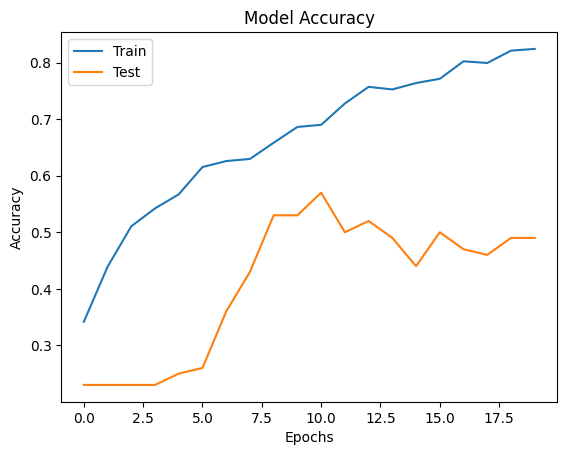

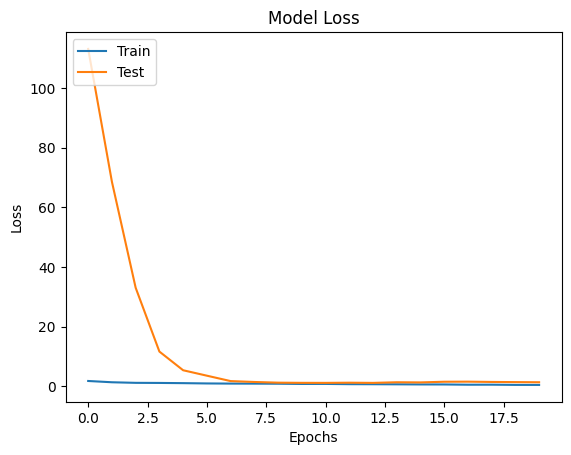

False


In [22]:
# Plot the training/validation accuracies/losses
plot(conv_3d1_3_model.history, conv_3d1_3.filepath)
# Save the model summary
save_summary(conv_3d1_3, conv_3d1_3_model, history_model3)

##### The Training are token time, so try to reduce the input size to speed it up

In [23]:
# Experimenting with different hyperparameters and reducing the input size from 160 to 120
# Model 4, frames_to_sample=30, batch_size=20, num_epochs=20, image_height=120, image_width=120
conv_3d1_4=ModelConv3D1()
conv_3d1_4.initialize_path(project_folder)
conv_3d1_4.initialize_image_properties(image_height=120,image_width=120)
conv_3d1_4.initialize_hyperparams(frames_to_sample=30,batch_size=20,num_epochs=20)
conv_3d1_4_model=conv_3d1_4.define_model("conv_3d1_4")
print("Total Params:", conv_3d1_4_model.count_params())
conv_3d1_4_model.summary()


Total Params: 1105093


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_12 (Conv3D)              │ (None, 30, 120, 120,   │         1,312 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 30, 120, 120,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 30, 120, 120,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_12 (MaxPooling3D) │ (None, 15, 60, 60, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_13 (Conv3D)              │ (None, 15, 60, 60, 32) │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 15, 60, 60, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 15, 60, 60, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_13 (MaxPooling3D) │ (None, 7, 30, 30, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_14 (Conv3D)              │ (None, 7, 30, 30, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 7, 30, 30, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 7, 30, 30, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_14 (MaxPooling3D) │ (None, 3, 15, 15, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_15 (Conv3D)              │ (None, 3, 15, 15, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 3, 15, 15, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 3, 15, 15, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_15 (MaxPooling3D) │ (None, 1, 7, 7, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,105,093 (4.22 MB)

 Trainable params: 1,104,229 (4.21 MB)

 Non-trainable params: 864 (3.38 KB)

In [25]:
# Show the total number of parameters and start the training
print("Total Params:", conv_3d1_4_model.count_params())
history_model4=conv_3d1_4.train_model(conv_3d1_4_model, augment_data=True)

Total Params: 1105093
Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.3085 - loss: 1.9114
Epoch 1: val_loss improved from inf to 63.57650, saving model to model/model_init_2024-04-1506_34_45.435012/model-00001-1.71704-0.34992-63.57650-0.23000.h5.keras

Epoch 1: val_loss improved from inf to 63.57650, saving model to model/model_init_2024-04-1506_34_45.435012/model-00001-1.71704-0.34992-63.57650-0.23000.h5.weights.h5
34/34 ━━━━━━━━━━━━━━━━━━━━ 157s 4s/step - categorical_accuracy: 0.3097 - loss: 1.9058 - val_categorical_accuracy: 0.2300 - val_loss: 63.5765 - learning_rate: 0.0100
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.3688 - loss: 1.5155
Epoch 2: val_loss improved from 63.57650 to 17.35290, saving model to model/model_init_2024-04-1506_34_45.435012/model-00002-1.40580-0.40422-17.35290-0.23000.h5.keras

Epoch 2: val_loss improved from 63.57650 to 17.35290, saving model to model/model_init_2024-04-1506_34_45.435012/model-00002-

dict_keys(['categorical_accuracy', 'loss', 'val_categorical_accuracy', 'val_loss', 'learning_rate'])
0.34992459416389465 0.23000000417232513 1.7170401811599731 63.576499938964844
0.6840120553970337 0.8625763058662415 0.6899999976158142 0.8164304494857788 16


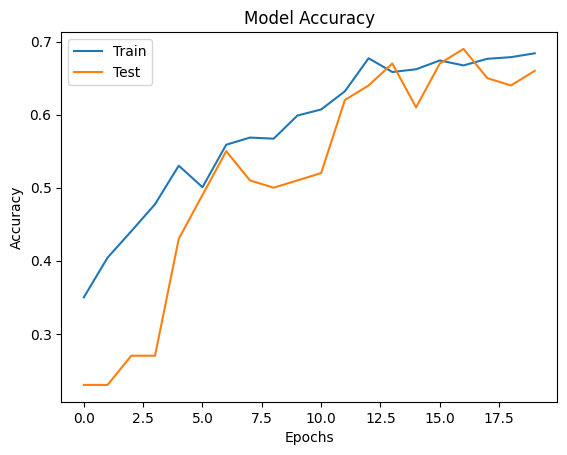

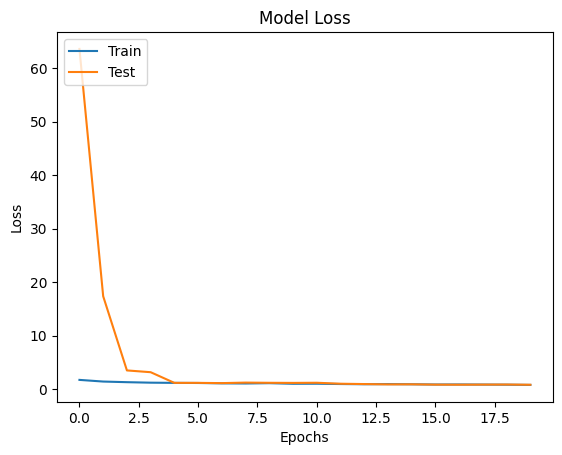

False


In [26]:
# Plot the training/validation accuracies/losses
plot(conv_3d1_4_model.history, conv_3d1_4.filepath)
# Save the model summary
save_summary(conv_3d1_4, conv_3d1_4_model, history_model4)

##### Still taking time, let train it without data augmentation

In [27]:
# Experimenting with different hyperparameters without data augmentation
# Model 5, frames_to_sample=30, batch_size=20, num_epochs=20, image_height=120, image_width=120 
conv_3d1_5=ModelConv3D1()
conv_3d1_5.initialize_path(project_folder)
conv_3d1_5.initialize_image_properties(image_height=120,image_width=120)
conv_3d1_5.initialize_hyperparams(frames_to_sample=30,batch_size=20,num_epochs=20)
conv_3d1_5_model=conv_3d1_5.define_model("conv_3d1_5")
print("Total Params:", conv_3d1_5_model.count_params())
conv_3d1_5_model.summary()

Total Params: 1105093


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_16 (Conv3D)              │ (None, 30, 120, 120,   │         1,312 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 30, 120, 120,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 30, 120, 120,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_16 (MaxPooling3D) │ (None, 15, 60, 60, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_17 (Conv3D)              │ (None, 15, 60, 60, 32) │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 15, 60, 60, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 15, 60, 60, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_17 (MaxPooling3D) │ (None, 7, 30, 30, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_18 (Conv3D)              │ (None, 7, 30, 30, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_18 (Activation)      │ (None, 7, 30, 30, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 7, 30, 30, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_18 (MaxPooling3D) │ (None, 3, 15, 15, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_19 (Conv3D)              │ (None, 3, 15, 15, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_19 (Activation)      │ (None, 3, 15, 15, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 3, 15, 15, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_19 (MaxPooling3D) │ (None, 1, 7, 7, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,105,093 (4.22 MB)

 Trainable params: 1,104,229 (4.21 MB)

 Non-trainable params: 864 (3.38 KB)

In [28]:
# Show the total number of parameters and start the training
print("Total Params:", conv_3d1_5_model.count_params())
history_model5=conv_3d1_5.train_model(conv_3d1_5_model, augment_data=False)

Total Params: 1105093
Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.3011 - loss: 1.9726
Epoch 1: val_loss improved from inf to 205.33186, saving model to model/model_init_2024-04-1507_20_24.463225/model-00001-1.75946-0.33484-205.33186-0.23000.h5.keras

Epoch 1: val_loss improved from inf to 205.33186, saving model to model/model_init_2024-04-1507_20_24.463225/model-00001-1.75946-0.33484-205.33186-0.23000.h5.weights.h5
34/34 ━━━━━━━━━━━━━━━━━━━━ 94s 3s/step - categorical_accuracy: 0.3021 - loss: 1.9665 - val_categorical_accuracy: 0.2300 - val_loss: 205.3319 - learning_rate: 0.0100
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.4859 - loss: 1.2647
Epoch 2: val_loss improved from 205.33186 to 33.36184, saving model to model/model_init_2024-04-1507_20_24.463225/model-00002-1.29727-0.46456-33.36184-0.23000.h5.keras

Epoch 2: val_loss improved from 205.33186 to 33.36184, saving model to model/model_init_2024-04-1507_20_24.463225/model-

dict_keys(['categorical_accuracy', 'loss', 'val_categorical_accuracy', 'val_loss', 'learning_rate'])
0.33484163880348206 0.23000000417232513 1.759458303451538 205.3318634033203
0.8386123776435852 0.6442893743515015 0.7200000286102295 0.7050970196723938 12


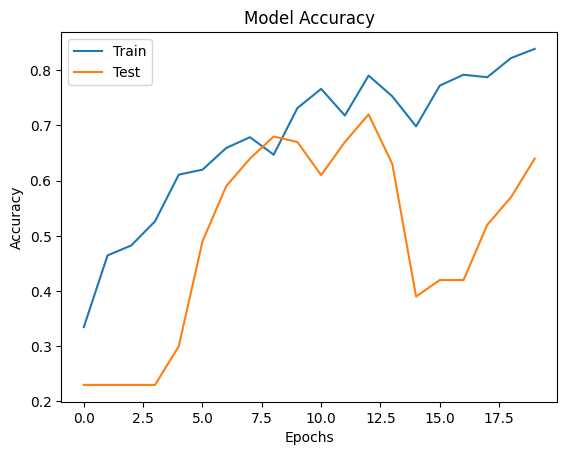

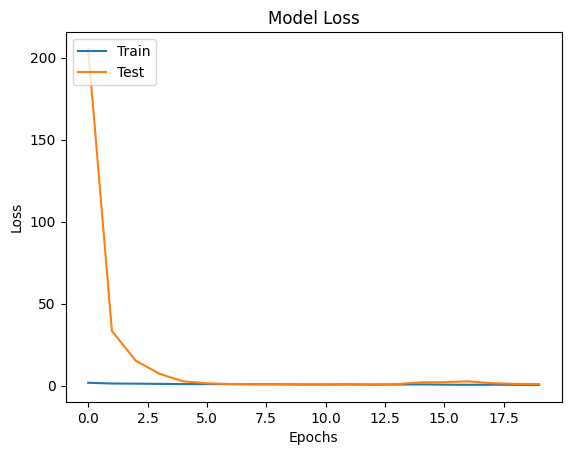

False


In [29]:
# Plot the training/validation accuracies/losses
plot(conv_3d1_5_model.history, conv_3d1_5.filepath)
# Save the model summary
save_summary(conv_3d1_5, conv_3d1_5_model, history_model5)

In [57]:
# Experimenting with different hyperparameters without data augmentation and reducing frames to sample to 20
# Model 6, frames_to_sample=20, batch_size=20, num_epochs=20, image_height=120, image_width=120
conv_3d1_6=ModelConv3D1()
conv_3d1_6.initialize_path(project_folder)
conv_3d1_6.initialize_image_properties(image_height=120,image_width=120)
conv_3d1_6.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=20)
conv_3d1_6_model=conv_3d1_6.define_model("conv_3d1_6")
print("Total Params:", conv_3d1_6_model.count_params())
conv_3d1_6_model.summary()


Total Params: 1105093


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_48 (Conv3D)              │ (None, 20, 120, 120,   │         1,312 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_48 (Activation)      │ (None, 20, 120, 120,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_70          │ (None, 20, 120, 120,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_48 (MaxPooling3D) │ (None, 10, 60, 60, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_49 (Conv3D)              │ (None, 10, 60, 60, 32) │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_49 (Activation)      │ (None, 10, 60, 60, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_71          │ (None, 10, 60, 60, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_49 (MaxPooling3D) │ (None, 5, 30, 30, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_50 (Conv3D)              │ (None, 5, 30, 30, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_50 (Activation)      │ (None, 5, 30, 30, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_72          │ (None, 5, 30, 30, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_50 (MaxPooling3D) │ (None, 2, 15, 15, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_51 (Conv3D)              │ (None, 2, 15, 15, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_51 (Activation)      │ (None, 2, 15, 15, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_73          │ (None, 2, 15, 15, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_51 (MaxPooling3D) │ (None, 1, 7, 7, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_74          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,105,093 (4.22 MB)

 Trainable params: 1,104,229 (4.21 MB)

 Non-trainable params: 864 (3.38 KB)

In [58]:
# Show the total number of parameters and start the training
print("Total Params:", conv_3d1_6_model.count_params())
history_model6=conv_3d1_6.train_model(conv_3d1_6_model, augment_data=False)

Total Params: 1105093
Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.3394 - loss: 1.8793
Epoch 1: val_loss improved from inf to 329.08267, saving model to model/model_init_2024-04-1512_09_00.330396/model-00001-1.71050-0.36802-329.08267-0.23000.h5.keras

Epoch 1: val_loss improved from inf to 329.08267, saving model to model/model_init_2024-04-1512_09_00.330396/model-00001-1.71050-0.36802-329.08267-0.23000.h5.weights.h5
34/34 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - categorical_accuracy: 0.3402 - loss: 1.8744 - val_categorical_accuracy: 0.2300 - val_loss: 329.0827 - learning_rate: 0.0100
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.4340 - loss: 1.4644
Epoch 2: val_loss improved from 329.08267 to 37.62624, saving model to model/model_init_2024-04-1512_09_00.330396/model-00002-1.37668-0.46456-37.62624-0.23000.h5.keras

Epoch 2: val_loss improved from 329.08267 to 37.62624, saving model to model/model_init_2024-04-1512_09_00.330396/model-

KeyboardInterrupt: 

dict_keys(['categorical_accuracy', 'loss', 'val_categorical_accuracy', 'val_loss', 'learning_rate'])
0.36199095845222473 0.23000000417232513 1.6275627613067627 523.2236938476562
0.7058823704719543 0.8450254797935486 0.6000000238418579 0.9749163389205933 11


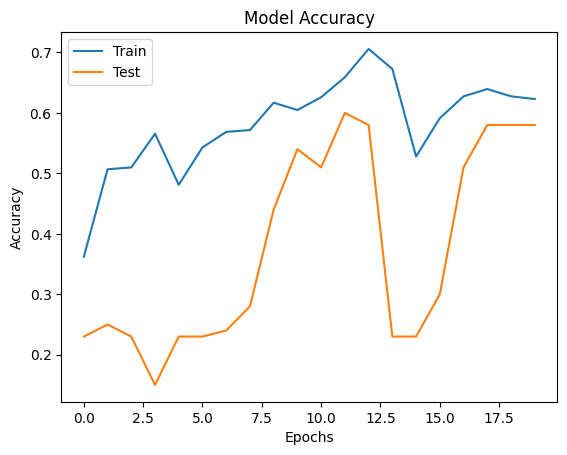

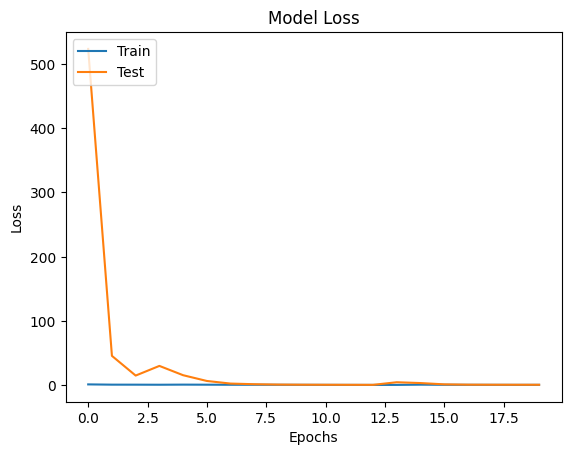

False


In [ ]:
# plot the training/validation accuracies/losses
plot(conv_3d1_6_model.history, conv_3d1_6.filepath)
# Save the model summary
save_summary(conv_3d1_6, conv_3d1_6_model, history_model6)

In [ ]:
# Experimenting with different hyperparameters without data augmentation and reducing frames to sample to 16
# Model 7, frames_to_sample=16, batch_size=20, num_epochs=20, image_height=120, image_width=120
conv_3d1_7=ModelConv3D1()
conv_3d1_7.initialize_path(project_folder)
conv_3d1_7.initialize_image_properties(image_height=120,image_width=120)
conv_3d1_7.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=20)
conv_3d1_7_model=conv_3d1_7.define_model("conv_3d1_7")
print("Total Params:", conv_3d1_7_model.count_params())
conv_3d1_7_model.summary()


Total Params: 1105093


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_24 (Conv3D)              │ (None, 16, 120, 120,   │         1,312 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_24 (Activation)      │ (None, 16, 120, 120,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 16, 120, 120,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_24 (MaxPooling3D) │ (None, 8, 60, 60, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_25 (Conv3D)              │ (None, 8, 60, 60, 32)  │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_25 (Activation)      │ (None, 8, 60, 60, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 8, 60, 60, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_25 (MaxPooling3D) │ (None, 4, 30, 30, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_26 (Conv3D)              │ (None, 4, 30, 30, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_26 (Activation)      │ (None, 4, 30, 30, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 4, 30, 30, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_26 (MaxPooling3D) │ (None, 2, 15, 15, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_27 (Conv3D)              │ (None, 2, 15, 15, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_27 (Activation)      │ (None, 2, 15, 15, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 2, 15, 15, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_27 (MaxPooling3D) │ (None, 1, 7, 7, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,105,093 (4.22 MB)

 Trainable params: 1,104,229 (4.21 MB)

 Non-trainable params: 864 (3.38 KB)

In [ ]:
# Show the total number of parameters and start the training
print("Total Params:", conv_3d1_7_model.count_params())
history_model7=conv_3d1_7.train_model(conv_3d1_7_model, augment_data=False)

Total Params: 1105093
Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.3276 - loss: 1.8758
Epoch 1: val_loss improved from inf to 203.38223, saving model to model/model_init_2024-04-1508_03_22.099086/model-00001-1.74921-0.34389-203.38223-0.23000.h5.keras

Epoch 1: val_loss improved from inf to 203.38223, saving model to model/model_init_2024-04-1508_03_22.099086/model-00001-1.74921-0.34389-203.38223-0.23000.h5.weights.h5
34/34 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - categorical_accuracy: 0.3280 - loss: 1.8722 - val_categorical_accuracy: 0.2300 - val_loss: 203.3822 - learning_rate: 0.0100
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.4294 - loss: 1.4056
Epoch 2: val_loss improved from 203.38223 to 33.52562, saving model to model/model_init_2024-04-1508_03_22.099086/model-00002-1.38297-0.43439-33.52562-0.23000.h5.keras

Epoch 2: val_loss improved from 203.38223 to 33.52562, saving model to model/model_init_2024-04-1508_03_22.099086/model-

dict_keys(['categorical_accuracy', 'loss', 'val_categorical_accuracy', 'val_loss', 'learning_rate'])
0.3438914120197296 0.23000000417232513 1.749207615852356 203.38223266601562
0.8521870374679565 0.4939110279083252 0.6600000262260437 0.9596157073974609 17


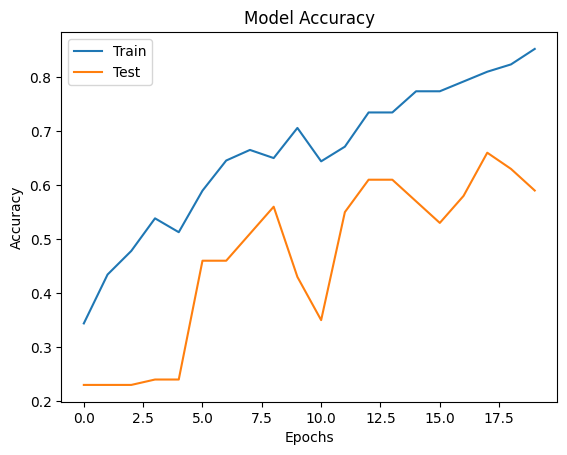

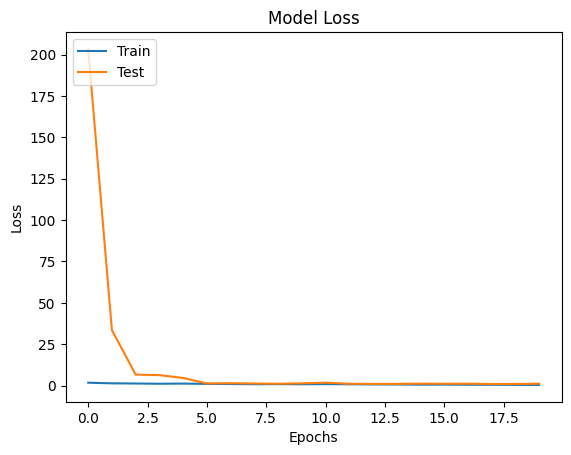

False


In [ ]:
# Plot the training/validation accuracies/losses
plot(conv_3d1_7_model.history, conv_3d1_7.filepath)
# Save the model summary
save_summary(conv_3d1_7, conv_3d1_7_model, history_model7)

In [ ]:
# Experimenting with different hyperparameters with data augmentation
# Model 8, frames_to_sample=16, batch_size=20, num_epochs=20, image_height=120, image_width=120
conv_3d1_8=ModelConv3D1()
conv_3d1_8.initialize_path(project_folder)
conv_3d1_8.initialize_image_properties(image_height=120,image_width=120)
conv_3d1_8.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=20)
conv_3d1_8_model=conv_3d1_8.define_model("conv_3d1_8")
print("Total Params:", conv_3d1_8_model.count_params())
conv_3d1_8_model.summary()

Total Params: 1105093


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_28 (Conv3D)              │ (None, 16, 120, 120,   │         1,312 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_28 (Activation)      │ (None, 16, 120, 120,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 16, 120, 120,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_28 (MaxPooling3D) │ (None, 8, 60, 60, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_29 (Conv3D)              │ (None, 8, 60, 60, 32)  │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_29 (Activation)      │ (None, 8, 60, 60, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 8, 60, 60, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_29 (MaxPooling3D) │ (None, 4, 30, 30, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_30 (Conv3D)              │ (None, 4, 30, 30, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_30 (Activation)      │ (None, 4, 30, 30, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ (None, 4, 30, 30, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_30 (MaxPooling3D) │ (None, 2, 15, 15, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_31 (Conv3D)              │ (None, 2, 15, 15, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_31 (Activation)      │ (None, 2, 15, 15, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_45          │ (None, 2, 15, 15, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_31 (MaxPooling3D) │ (None, 1, 7, 7, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_46          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,105,093 (4.22 MB)

 Trainable params: 1,104,229 (4.21 MB)

 Non-trainable params: 864 (3.38 KB)

In [ ]:
# Show the total number of parameters and start the training
print("Total Params:", conv_3d1_8_model.count_params())
history_model8=conv_3d1_8.train_model(conv_3d1_8_model, augment_data=True)

Total Params: 1105093
Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.2758 - loss: 1.9792
Epoch 1: val_loss improved from inf to 111.48183, saving model to model/model_init_2024-04-1508_17_13.564037/model-00001-1.78302-0.30769-111.48183-0.25000.h5.keras

Epoch 1: val_loss improved from inf to 111.48183, saving model to model/model_init_2024-04-1508_17_13.564037/model-00001-1.78302-0.30769-111.48183-0.25000.h5.weights.h5
34/34 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - categorical_accuracy: 0.2767 - loss: 1.9736 - val_categorical_accuracy: 0.2500 - val_loss: 111.4818 - learning_rate: 0.0100
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.4072 - loss: 1.4203
Epoch 2: val_loss improved from 111.48183 to 32.07200, saving model to model/model_init_2024-04-1508_17_13.564037/model-00002-1.43111-0.39442-32.07200-0.23000.h5.keras

Epoch 2: val_loss improved from 111.48183 to 32.07200, saving model to model/model_init_2024-04-1508_17_13.564037/model-

dict_keys(['categorical_accuracy', 'loss', 'val_categorical_accuracy', 'val_loss', 'learning_rate'])
0.3076923191547394 0.25 1.7830206155776978 111.48182678222656
0.6877828240394592 0.9799836277961731 0.6200000047683716 0.9494045972824097 14


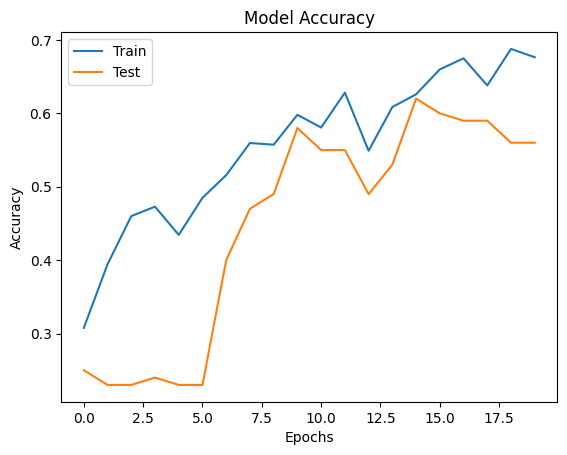

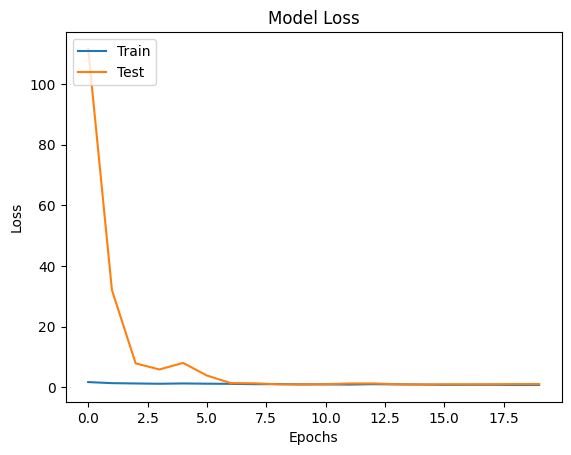

False


In [ ]:
# Plot the training/validation accuracies/losses
plot(conv_3d1_8_model.history, conv_3d1_8.filepath)
# Save the model summary
save_summary(conv_3d1_8, conv_3d1_8_model, history_model8)

#### Simple Model with Adam

In [ ]:
# Simple Model with Adam optimizer
class ModelConv3D2(ModelBuilder):
    
    def define_model(self, name='model_conv3d_1'):
        self.name = name
        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Conv3D(64, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Conv3D(128, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimizer = optimizers.Adam()
        
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
# Experimenting with different hyperparameters with data augmentation
# Model 9, frames_to_sample=30, batch_size=20, num_epochs=20, image_height=120, image_width=120
conv_3d2_1=ModelConv3D2()
conv_3d2_1.initialize_path(project_folder)
conv_3d2_1.initialize_image_properties(image_height=120,image_width=120)
conv_3d2_1.initialize_hyperparams(frames_to_sample=30,batch_size=20,num_epochs=20)
conv_3d2_1_model=conv_3d2_1.define_model("conv_3d2_1")
print("Total Params:", conv_3d2_1_model.count_params())
conv_3d2_1_model.summary()

Total Params: 1105093


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_32 (Conv3D)              │ (None, 30, 120, 120,   │         1,312 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_32 (Activation)      │ (None, 30, 120, 120,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_48          │ (None, 30, 120, 120,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_32 (MaxPooling3D) │ (None, 15, 60, 60, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_33 (Conv3D)              │ (None, 15, 60, 60, 32) │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_33 (Activation)      │ (None, 15, 60, 60, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_49          │ (None, 15, 60, 60, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_33 (MaxPooling3D) │ (None, 7, 30, 30, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_34 (Conv3D)              │ (None, 7, 30, 30, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_34 (Activation)      │ (None, 7, 30, 30, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_50          │ (None, 7, 30, 30, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_34 (MaxPooling3D) │ (None, 3, 15, 15, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_35 (Conv3D)              │ (None, 3, 15, 15, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_35 (Activation)      │ (None, 3, 15, 15, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_51          │ (None, 3, 15, 15, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_35 (MaxPooling3D) │ (None, 1, 7, 7, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_52          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,105,093 (4.22 MB)

 Trainable params: 1,104,229 (4.21 MB)

 Non-trainable params: 864 (3.38 KB)

In [ ]:
# Show the total number of parameters and start the training
print("Total Params:", conv_3d2_1_model.count_params())
history_model9=conv_3d2_1.train_model(conv_3d2_1_model, augment_data=True)

Total Params: 1105093
Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.2904 - loss: 1.9995
Epoch 1: val_loss improved from inf to 1.53291, saving model to model/model_init_2024-04-1508_46_05.856795/model-00001-1.77476-0.33183-1.53291-0.30000.h5.keras

Epoch 1: val_loss improved from inf to 1.53291, saving model to model/model_init_2024-04-1508_46_05.856795/model-00001-1.77476-0.33183-1.53291-0.30000.h5.weights.h5
34/34 ━━━━━━━━━━━━━━━━━━━━ 154s 4s/step - categorical_accuracy: 0.2916 - loss: 1.9930 - val_categorical_accuracy: 0.3000 - val_loss: 1.5329 - learning_rate: 0.0010
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.4864 - loss: 1.3264
Epoch 2: val_loss did not improve from 1.53291

Epoch 2: val_loss did not improve from 1.53291
34/34 ━━━━━━━━━━━━━━━━━━━━ 140s 4s/step - categorical_accuracy: 0.4862 - loss: 1.3271 - val_categorical_accuracy: 0.2600 - val_loss: 2.2720 - learning_rate: 0.0010
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0

dict_keys(['categorical_accuracy', 'loss', 'val_categorical_accuracy', 'val_loss', 'learning_rate'])
0.33182504773139954 0.30000001192092896 1.7747604846954346 1.5329092741012573
0.686274528503418 0.9295973777770996 0.33000001311302185 1.8878170251846313 8


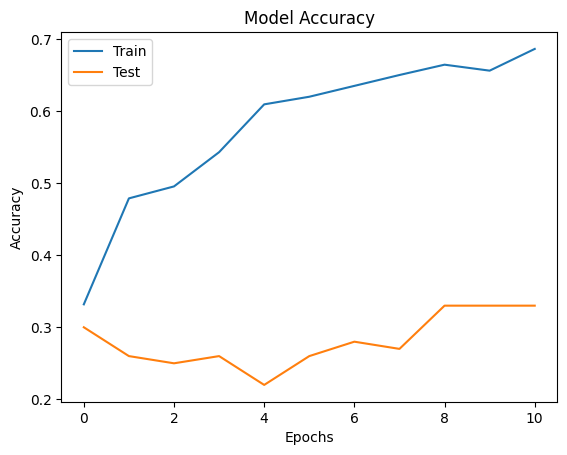

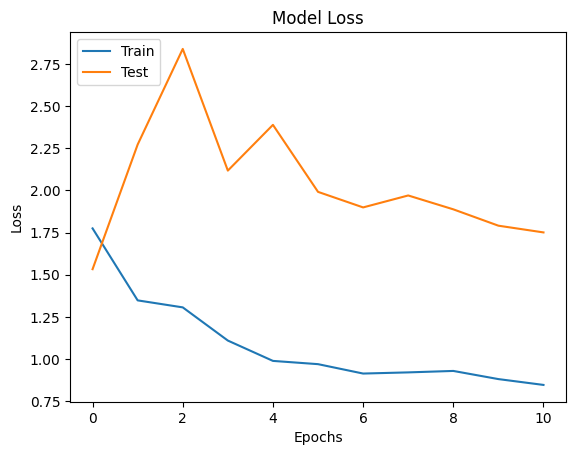

False


In [ ]:
# Plot the training/validation accuracies/losses
plot(conv_3d2_1_model.history, conv_3d2_1.filepath)
# Save the model summary
save_summary(conv_3d2_1, conv_3d2_1_model, history_model9)

In [ ]:
# By observing the model 9 summary and the validation accuracies is not increasing and the model is overfitting on training data.
# Also, the validation loss is not able to decrease. So, we need to change the model architecture and try to reduce the number of parameters.
# To speed up the architecture modification, we will reduce the number of epochs to 5.

# Simple Model with Adam optimizer and regularization L2
class ModelConv3D3(ModelBuilder):
    
    def define_model(self, name='model_conv3d_1'):
        self.name = name
        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Conv3D(64, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Conv3D(128, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu', kernel_regularizer=l2(0.01)))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu', kernel_regularizer=l2(0.01)))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimizer = optimizers.Adam()
        
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
# Experimenting with regularization L2
# Model 10, frames_to_sample=30, batch_size=20, num_epochs=5, image_height=120, image_width=120
conv_3d3_1=ModelConv3D3()
conv_3d3_1.initialize_path(project_folder)
conv_3d3_1.initialize_image_properties(image_height=120,image_width=120)
conv_3d3_1.initialize_hyperparams(frames_to_sample=30,batch_size=20,num_epochs=5)
conv_3d3_1_model=conv_3d3_1.define_model("conv_3d3_1")

print("Total Params:", conv_3d3_1_model.count_params())
conv_3d3_1_model.summary()


Total Params: 1105093


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_44 (Conv3D)              │ (None, 30, 120, 120,   │         1,312 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_44 (Activation)      │ (None, 30, 120, 120,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_64          │ (None, 30, 120, 120,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_44 (MaxPooling3D) │ (None, 15, 60, 60, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_45 (Conv3D)              │ (None, 15, 60, 60, 32) │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_45 (Activation)      │ (None, 15, 60, 60, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_65          │ (None, 15, 60, 60, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_45 (MaxPooling3D) │ (None, 7, 30, 30, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_46 (Conv3D)              │ (None, 7, 30, 30, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_46 (Activation)      │ (None, 7, 30, 30, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_66          │ (None, 7, 30, 30, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_46 (MaxPooling3D) │ (None, 3, 15, 15, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_47 (Conv3D)              │ (None, 3, 15, 15, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_47 (Activation)      │ (None, 3, 15, 15, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_67          │ (None, 3, 15, 15, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_47 (MaxPooling3D) │ (None, 1, 7, 7, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_68          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,105,093 (4.22 MB)

 Trainable params: 1,104,229 (4.21 MB)

 Non-trainable params: 864 (3.38 KB)

In [ ]:
# Show the total number of parameters and start the training
print("Total Params:", conv_3d3_1_model.count_params())
history_model10=conv_3d3_1.train_model(conv_3d3_1_model, augment_data=True)

Total Params: 1105093


Epoch 1/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.3044 - loss: 5.3264
Epoch 1: val_loss improved from inf to 4.81670, saving model to model/model_init_2024-04-1511_50_21.506471/model-00001-5.10107-0.35671-4.81670-0.26000.h5.keras

Epoch 1: val_loss improved from inf to 4.81670, saving model to model/model_init_2024-04-1511_50_21.506471/model-00001-5.10107-0.35671-4.81670-0.26000.h5.weights.h5
34/34 ━━━━━━━━━━━━━━━━━━━━ 161s 5s/step - categorical_accuracy: 0.3059 - loss: 5.3200 - val_categorical_accuracy: 0.2600 - val_loss: 4.8167 - learning_rate: 0.0010
Epoch 2/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.4186 - loss: 4.5886
Epoch 2: val_loss improved from 4.81670 to 4.46894, saving model to model/model_init_2024-04-1511_50_21.506471/model-00002-4.45786-0.44646-4.46894-0.27000.h5.keras

Epoch 2: val_loss improved from 4.81670 to 4.46894, saving model to model/model_init_2024-04-1511_50_21.506471/model-00002-4.45786-0.44646-4.46894-0.27000.h5

dict_keys(['categorical_accuracy', 'loss', 'val_categorical_accuracy', 'val_loss', 'learning_rate'])
0.3567119240760803 0.25999999046325684 5.101070404052734 4.8167009353637695
0.5829562544822693 3.4586353302001953 0.30000001192092896 4.014405250549316 3


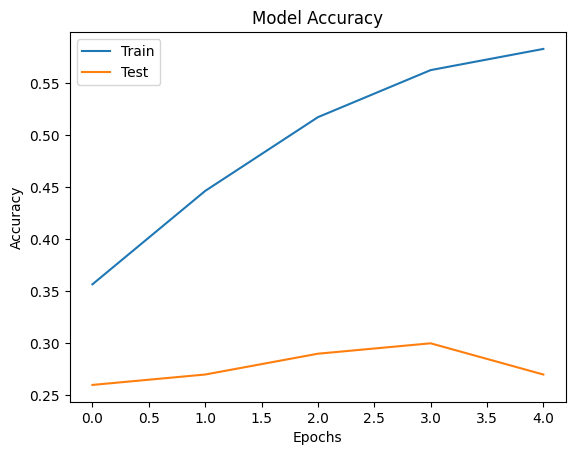

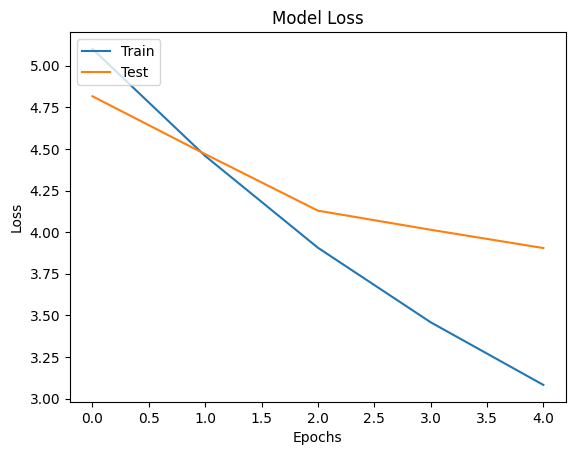

False


In [59]:
# Plot the training/validation accuracies/losses
plot(conv_3d3_1_model.history, conv_3d3_1.filepath)
# Save the model summary
save_summary(conv_3d3_1, conv_3d3_1_model, history_model10)

In [60]:
# We can see the vailation accuracy has increased and the model loss has decreased.
# So we experiment 20 epochs with the same model architecture.
# Model 11, frames_to_sample=30, batch_size=20, num_epochs=20, image_height=120, image_width=120
conv_3d3_2=ModelConv3D3()
conv_3d3_2.initialize_path(project_folder)
conv_3d3_2.initialize_image_properties(image_height=120,image_width=120)
conv_3d3_2.initialize_hyperparams(frames_to_sample=30,batch_size=20,num_epochs=20)
conv_3d3_2_model=conv_3d3_2.define_model("conv_3d3_2")
print("Total Params:", conv_3d3_2_model.count_params())
conv_3d3_2_model.summary()

Total Params: 1105093


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_52 (Conv3D)              │ (None, 30, 120, 120,   │         1,312 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_52 (Activation)      │ (None, 30, 120, 120,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_76          │ (None, 30, 120, 120,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_52 (MaxPooling3D) │ (None, 15, 60, 60, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_53 (Conv3D)              │ (None, 15, 60, 60, 32) │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_53 (Activation)      │ (None, 15, 60, 60, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_77          │ (None, 15, 60, 60, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_53 (MaxPooling3D) │ (None, 7, 30, 30, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_54 (Conv3D)              │ (None, 7, 30, 30, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_54 (Activation)      │ (None, 7, 30, 30, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_78          │ (None, 7, 30, 30, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_54 (MaxPooling3D) │ (None, 3, 15, 15, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_55 (Conv3D)              │ (None, 3, 15, 15, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_55 (Activation)      │ (None, 3, 15, 15, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_79          │ (None, 3, 15, 15, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_55 (MaxPooling3D) │ (None, 1, 7, 7, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_80          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,105,093 (4.22 MB)

 Trainable params: 1,104,229 (4.21 MB)

 Non-trainable params: 864 (3.38 KB)

In [61]:
# Show the total number of parameters and start the training
print("Total Params:", conv_3d3_2_model.count_params())
history_model11=conv_3d3_2.train_model(conv_3d3_2_model, augment_data=True)

Total Params: 1105093
Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.2920 - loss: 5.3727
Epoch 1: val_loss improved from inf to 4.75182, saving model to model/model_init_2024-04-1512_15_53.497631/model-00001-5.20330-0.33560-4.75182-0.33000.h5.keras

Epoch 1: val_loss improved from inf to 4.75182, saving model to model/model_init_2024-04-1512_15_53.497631/model-00001-5.20330-0.33560-4.75182-0.33000.h5.weights.h5
34/34 ━━━━━━━━━━━━━━━━━━━━ 155s 5s/step - categorical_accuracy: 0.2933 - loss: 5.3679 - val_categorical_accuracy: 0.3300 - val_loss: 4.7518 - learning_rate: 0.0010
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.4685 - loss: 4.5635
Epoch 2: val_loss improved from 4.75182 to 4.67223, saving model to model/model_init_2024-04-1512_15_53.497631/model-00002-4.46665-0.45626-4.67223-0.22000.h5.keras

Epoch 2: val_loss improved from 4.75182 to 4.67223, saving model to model/model_init_2024-04-1512_15_53.497631/model-00002-4.46665-0.

dict_keys(['categorical_accuracy', 'loss', 'val_categorical_accuracy', 'val_loss', 'learning_rate'])
0.3355957865715027 0.33000001311302185 5.203303813934326 4.751818656921387
0.8190045356750488 1.2410207986831665 0.699999988079071 1.4611740112304688 19


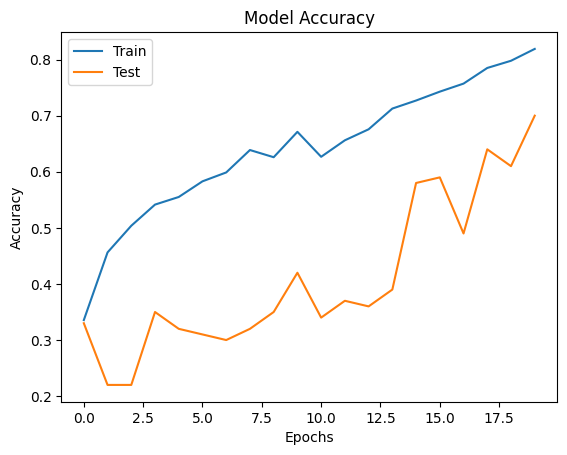

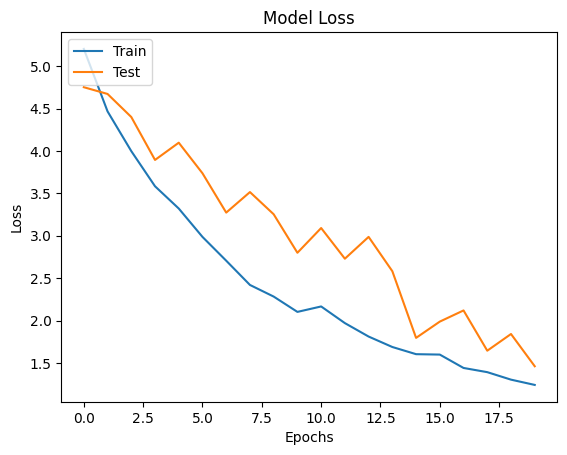

False


In [62]:
# Plot the training/validation accuracies/losses
plot(conv_3d3_2_model.history, conv_3d3_2.filepath)
# Save the model summary
save_summary(conv_3d3_2, conv_3d3_2_model, history_model11)

look well
to reduce parameter
create a model with agru 
[16,32,64,128] -> [8,16,32,64]
[128,64,5] -> [256,128,5]

In [ ]:
# Result with regularization L2 is better than the previous models. The accuracy has increased and the loss has decreased.
# We can try to reduce parameters by reducing the number of filters in the convolution layers.

In [65]:
# Simple Model with Adam optimizer and regularization L2 in experiment on different number of filters
class ModelConv3D4(ModelBuilder):
    
    def define_model(self, name='model_conv3d_1', filters=[8,16,32,64], dropout=[0.5,0.25], dense_neurons=[128,64,5]):
        self.name = name
        model = Sequential()
        model.add(Conv3D(filters[0], (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Conv3D(filters[1], (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Conv3D(filters[2], (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Conv3D(filters[3], (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons[0],activation='relu', kernel_regularizer=l2(0.01)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout[0]))

        model.add(Dense(dense_neurons[1],activation='relu', kernel_regularizer=l2(0.01)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout[1]))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimizer = optimizers.Adam()
        
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [66]:
# Experimenting with regularization L2 and different number of filters
# Model 12, frames_to_sample=30, batch_size=20, num_epochs=20, image_height=120, image_width=120
conv_3d4_1=ModelConv3D4()
conv_3d4_1.initialize_path(project_folder)
conv_3d4_1.initialize_image_properties(image_height=120,image_width=120)
conv_3d4_1.initialize_hyperparams(frames_to_sample=30,batch_size=20,num_epochs=20)
conv_3d4_1_model=conv_3d4_1.define_model("conv_3d4_1", filters=[8,16,32,64], dropout=[0.5,0.25], dense_neurons=[128,64,5])
print("Total Params:", conv_3d4_1_model.count_params())
conv_3d4_1_model.summary()

Total Params: 484709


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_60 (Conv3D)              │ (None, 30, 120, 120,   │           656 │
│                                 │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_60 (Activation)      │ (None, 30, 120, 120,   │             0 │
│                                 │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_86          │ (None, 30, 120, 120,   │            32 │
│ (BatchNormalization)            │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_60 (MaxPooling3D) │ (None, 15, 60, 60, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_61 (Conv3D)              │ (None, 15, 60, 60, 16) │         3,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_61 (Activation)      │ (None, 15, 60, 60, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_87          │ (None, 15, 60, 60, 16) │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_61 (MaxPooling3D) │ (None, 7, 30, 30, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_62 (Conv3D)              │ (None, 7, 30, 30, 32)  │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_62 (Activation)      │ (None, 7, 30, 30, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_88          │ (None, 7, 30, 30, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_62 (MaxPooling3D) │ (None, 3, 15, 15, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_63 (Conv3D)              │ (None, 3, 15, 15, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_63 (Activation)      │ (None, 3, 15, 15, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_89          │ (None, 3, 15, 15, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_63 (MaxPooling3D) │ (None, 1, 7, 7, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_90          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 484,709 (1.85 MB)

 Trainable params: 484,085 (1.85 MB)

 Non-trainable params: 624 (2.44 KB)

In [67]:
# Show the total number of parameters and start the training
print("Total Params:", conv_3d4_1_model.count_params())
history_model12=conv_3d4_1.train_model(conv_3d4_1_model, augment_data=True)

Total Params: 484709
Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.2693 - loss: 5.3539
Epoch 1: val_loss improved from inf to 4.86225, saving model to model/model_init_2024-04-1513_54_21.696681/model-00001-5.12747-0.31900-4.86225-0.23000.h5.keras

Epoch 1: val_loss improved from inf to 4.86225, saving model to model/model_init_2024-04-1513_54_21.696681/model-00001-5.12747-0.31900-4.86225-0.23000.h5.weights.h5
34/34 ━━━━━━━━━━━━━━━━━━━━ 162s 5s/step - categorical_accuracy: 0.2707 - loss: 5.3474 - val_categorical_accuracy: 0.2300 - val_loss: 4.8622 - learning_rate: 0.0010
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.4003 - loss: 4.6405
Epoch 2: val_loss improved from 4.86225 to 4.75363, saving model to model/model_init_2024-04-1513_54_21.696681/model-00002-4.53253-0.41931-4.75363-0.26000.h5.keras

Epoch 2: val_loss improved from 4.86225 to 4.75363, saving model to model/model_init_2024-04-1513_54_21.696681/model-00002-4.53253-0.4

dict_keys(['categorical_accuracy', 'loss', 'val_categorical_accuracy', 'val_loss', 'learning_rate'])
0.31900453567504883 0.23000000417232513 5.127467155456543 4.862248420715332
0.7647058963775635 1.5602269172668457 0.6600000262260437 1.8127403259277344 19


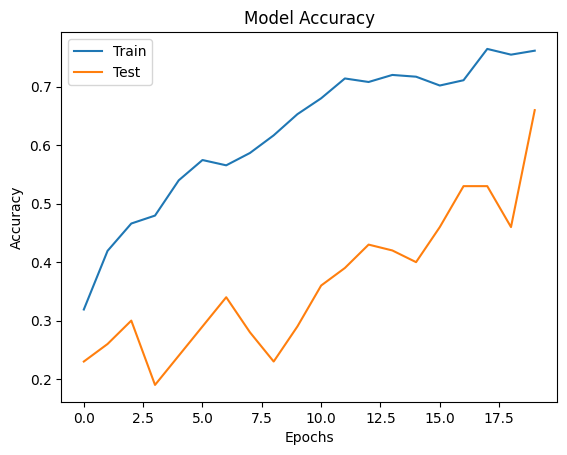

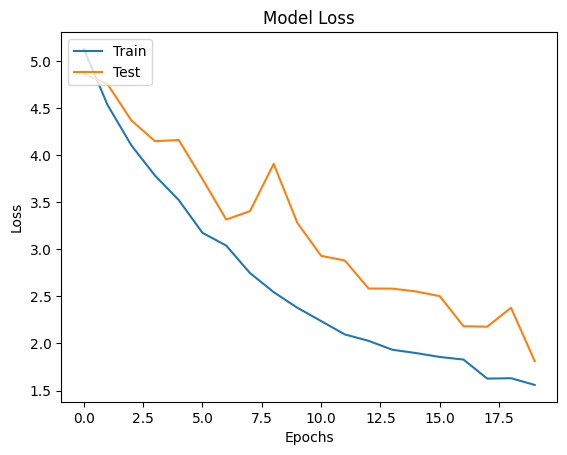

False


In [68]:
# Plot the training/validation accuracies/losses
plot(conv_3d4_1_model.history, conv_3d4_1.filepath)
# Save the model summary
save_summary(conv_3d4_1, conv_3d4_1_model, history_model12)

In [13]:
# With rotaion augment

class ModelBuilder_2(metaclass= abc.ABCMeta):
    # initialisng the path where project data resides
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)

    # initialising the image properties    
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
        

    # initialising the batch size, frames to sample and the no. of epochs
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
    # MOST IMPORTANT PART HERE - The generator function        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
   
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx):
                #performing image reading and resizing
                image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                #image_resized=imresize(image,(self.image_height,self.image_width,3))
                image_resized = crop_resize_img(image,self.image_width,self.image_height)
                # image_resized = cv2.resize(image, (self.image_width,self.image_height), interpolation = cv2.INTER_AREA)

                #normalizing the images
                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    # Randomly shifting the image to the left or right
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    # cropping the images to have the targeted gestures and remove the noise from the images.
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    # image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    image_resized = crop_resize_img(cropped, self.image_width, self.image_height)
                    # image_resized = cv2.resize(cropped, (self.image_width,self.image_height), interpolation = cv2.INTER_AREA)

                    M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))

                    batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        start_time = time.perf_counter()
                
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        if not os.path.exists('model'):
            os.mkdir('model')

        model_name = 'model/' + 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
        self.filepath = filepath

        checkpoint = ModelCheckpoint(filepath + '.keras', monitor='val_loss', verbose=1, save_freq='epoch', save_best_only=True, save_weights_only=False, mode='auto')
        checkpoint_h5 = ModelCheckpoint(filepath + '.weights.h5', monitor='val_loss', verbose=1, save_freq='epoch', save_best_only=True, save_weights_only=True, mode='auto')
        
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)
        earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
        
        logdir = "logs/scalars/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = TensorBoard(log_dir=logdir)
        csv_logger = CSVLogger(f'{filepath}.log')

        callbacks_list = [checkpoint, checkpoint_h5, LR, earlystop, tensorboard_callback, csv_logger]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        # history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
        #                     callbacks=callbacks_list, validation_data=val_generator, 
        #                     validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, initial_epoch=0)
        end_time = time.perf_counter()
        self.total_time = end_time - start_time
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass
    
    

In [14]:
# Do more data Augmentation with ModelBuilder_2
# Simple Model with Adam optimizer and regularization L2 in experiment on different number of filters
class ModelConv3D5(ModelBuilder_2):
    
    def define_model(self, name='model_conv3d_1', filters=[8,16,32,64], dropout=[0.5,0.25], dense_neurons=[128,64,5]):
        self.name = name
        model = Sequential()
        model.add(Conv3D(filters[0], (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Conv3D(filters[1], (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Conv3D(filters[2], (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Conv3D(filters[3], (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons[0],activation='relu', kernel_regularizer=l2(0.01)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout[0]))

        model.add(Dense(dense_neurons[1],activation='relu', kernel_regularizer=l2(0.01)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout[1]))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimizer = optimizers.Adam()
        
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model



In [71]:
# Experimenting with Rotate augment
# Model 13, frames_to_sample=30, batch_size=20, num_epochs=20, image_height=120, image_width=120
conv_3d5_1=ModelConv3D5()
conv_3d5_1.initialize_path(project_folder)
conv_3d5_1.initialize_image_properties(image_height=120,image_width=120)
conv_3d5_1.initialize_hyperparams(frames_to_sample=30,batch_size=20,num_epochs=20)
conv_3d5_1_model=conv_3d5_1.define_model("conv_3d5_1", filters=[8,16,32,64], dropout=[0.5,0.25], dense_neurons=[128,64,5])
print("Total Params:", conv_3d5_1_model.count_params())
conv_3d5_1_model.summary()

Total Params: 484709


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_64 (Conv3D)              │ (None, 30, 120, 120,   │           656 │
│                                 │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_64 (Activation)      │ (None, 30, 120, 120,   │             0 │
│                                 │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_92          │ (None, 30, 120, 120,   │            32 │
│ (BatchNormalization)            │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_64 (MaxPooling3D) │ (None, 15, 60, 60, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_65 (Conv3D)              │ (None, 15, 60, 60, 16) │         3,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_65 (Activation)      │ (None, 15, 60, 60, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_93          │ (None, 15, 60, 60, 16) │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_65 (MaxPooling3D) │ (None, 7, 30, 30, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_66 (Conv3D)              │ (None, 7, 30, 30, 32)  │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_66 (Activation)      │ (None, 7, 30, 30, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_94          │ (None, 7, 30, 30, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_66 (MaxPooling3D) │ (None, 3, 15, 15, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_67 (Conv3D)              │ (None, 3, 15, 15, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_67 (Activation)      │ (None, 3, 15, 15, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_95          │ (None, 3, 15, 15, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_67 (MaxPooling3D) │ (None, 1, 7, 7, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_96          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 484,709 (1.85 MB)

 Trainable params: 484,085 (1.85 MB)

 Non-trainable params: 624 (2.44 KB)

In [72]:
# Show the total number of parameters and start the training
print("Total Params:", conv_3d5_1_model.count_params())
history_model13=conv_3d5_1.train_model(conv_3d5_1_model, augment_data=True)

Total Params: 484709
Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.2798 - loss: 5.4013
Epoch 1: val_loss improved from inf to 4.97778, saving model to model/model_init_2024-04-1515_07_58.447435/model-00001-5.17974-0.32881-4.97778-0.25000.h5.keras

Epoch 1: val_loss improved from inf to 4.97778, saving model to model/model_init_2024-04-1515_07_58.447435/model-00001-5.17974-0.32881-4.97778-0.25000.h5.weights.h5
34/34 ━━━━━━━━━━━━━━━━━━━━ 159s 5s/step - categorical_accuracy: 0.2812 - loss: 5.3950 - val_categorical_accuracy: 0.2500 - val_loss: 4.9778 - learning_rate: 0.0010
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.4299 - loss: 4.5615
Epoch 2: val_loss did not improve from 4.97778

Epoch 2: val_loss did not improve from 4.97778
34/34 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - categorical_accuracy: 0.4300 - loss: 4.5604 - val_categorical_accuracy: 0.1800 - val_loss: 5.2005 - learning_rate: 0.0010
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s

dict_keys(['categorical_accuracy', 'loss', 'val_categorical_accuracy', 'val_loss', 'learning_rate'])
0.328808456659317 0.25 5.179737091064453 4.977779865264893
0.7518853545188904 2.4298887252807617 0.7400000095367432 2.520602226257324 19


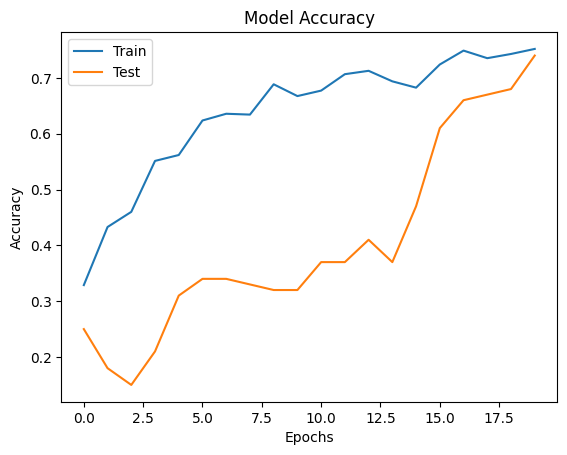

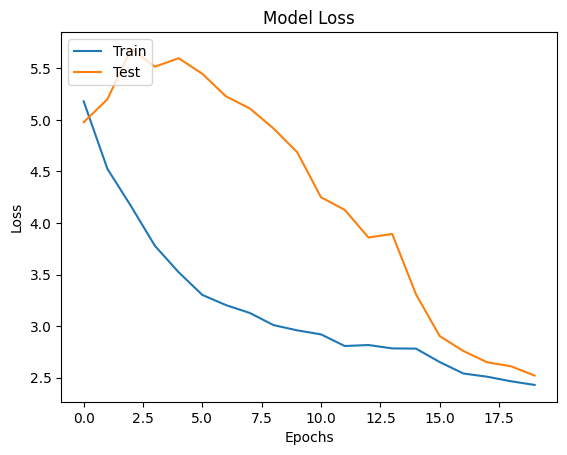

False


In [73]:
# Plot the training/validation accuracies/losses
plot(conv_3d5_1_model.history, conv_3d5_1.filepath)
# Save the model summary
save_summary(conv_3d5_1, conv_3d5_1_model, history_model13)

In [74]:

# Simple Model(Swipe activation function and batchnomal) with Adam optimizer and regularization L2 
# in experiment on different number of filters with ModelBuilder_2
class ModelConv3D6(ModelBuilder_2):
    
    def define_model(self, name='model_conv3d_1', filters=[8,16,32,64], dropout=[0.5,0.25], dense_neurons=[128,64,5]):
        self.name = name
        model = Sequential()
        model.add(Conv3D(filters[0], (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Conv3D(filters[1], (3, 3, 3), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Conv3D(filters[2], (3, 3, 3), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Conv3D(filters[3], (3, 3, 3), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons[0],activation='relu', kernel_regularizer=l2(0.01)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout[0]))

        model.add(Dense(dense_neurons[1],activation='relu', kernel_regularizer=l2(0.01)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout[1]))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimizer = optimizers.Adam()
        
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model



In [75]:
# Experimenting with BatchNormalization and Swipe activation function
# Model 14, frames_to_sample=30, batch_size=20, num_epochs=20, image_height=120, image_width=120
conv_3d6_1=ModelConv3D6()
conv_3d6_1.initialize_path(project_folder)
conv_3d6_1.initialize_image_properties(image_height=120,image_width=120)
conv_3d6_1.initialize_hyperparams(frames_to_sample=30,batch_size=20,num_epochs=20)
conv_3d6_1_model=conv_3d6_1.define_model("conv_3d6_1", filters=[8,16,32,64], dropout=[0.5,0.25], dense_neurons=[128,64,5])
print("Total Params:", conv_3d6_1_model.count_params())
conv_3d6_1_model.summary()

Total Params: 484709


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_68 (Conv3D)              │ (None, 30, 120, 120,   │           656 │
│                                 │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_98          │ (None, 30, 120, 120,   │            32 │
│ (BatchNormalization)            │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_68 (Activation)      │ (None, 30, 120, 120,   │             0 │
│                                 │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_68 (MaxPooling3D) │ (None, 15, 60, 60, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_69 (Conv3D)              │ (None, 15, 60, 60, 16) │         3,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_99          │ (None, 15, 60, 60, 16) │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_69 (Activation)      │ (None, 15, 60, 60, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_69 (MaxPooling3D) │ (None, 7, 30, 30, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_70 (Conv3D)              │ (None, 7, 30, 30, 32)  │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_100         │ (None, 7, 30, 30, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_70 (Activation)      │ (None, 7, 30, 30, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_70 (MaxPooling3D) │ (None, 3, 15, 15, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_71 (Conv3D)              │ (None, 3, 15, 15, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_101         │ (None, 3, 15, 15, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_71 (Activation)      │ (None, 3, 15, 15, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_71 (MaxPooling3D) │ (None, 1, 7, 7, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_17 (Flatten)            │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_102         │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 484,709 (1.85 MB)

 Trainable params: 484,085 (1.85 MB)

 Non-trainable params: 624 (2.44 KB)

In [76]:
# Show the total number of parameters and start the training
print("Total Params:", conv_3d6_1_model.count_params())
history_model14=conv_3d6_1.train_model(conv_3d6_1_model, augment_data=True)

Total Params: 484709
Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.3248 - loss: 5.1160
Epoch 1: val_loss improved from inf to 4.41003, saving model to model/model_init_2024-04-1520_22_39.011674/model-00001-4.93014-0.33484-4.41003-0.37000.h5.keras

Epoch 1: val_loss improved from inf to 4.41003, saving model to model/model_init_2024-04-1520_22_39.011674/model-00001-4.93014-0.33484-4.41003-0.37000.h5.weights.h5
34/34 ━━━━━━━━━━━━━━━━━━━━ 176s 5s/step - categorical_accuracy: 0.3251 - loss: 5.1107 - val_categorical_accuracy: 0.3700 - val_loss: 4.4100 - learning_rate: 0.0010
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.4618 - loss: 4.2753
Epoch 2: val_loss did not improve from 4.41003

Epoch 2: val_loss did not improve from 4.41003
34/34 ━━━━━━━━━━━━━━━━━━━━ 156s 5s/step - categorical_accuracy: 0.4621 - loss: 4.2711 - val_categorical_accuracy: 0.1700 - val_loss: 4.5991 - learning_rate: 0.0010
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s

dict_keys(['categorical_accuracy', 'loss', 'val_categorical_accuracy', 'val_loss', 'learning_rate'])
0.33484163880348206 0.3700000047683716 4.930140972137451 4.410031318664551
0.7541478276252747 2.088637113571167 0.699999988079071 2.270202875137329 18


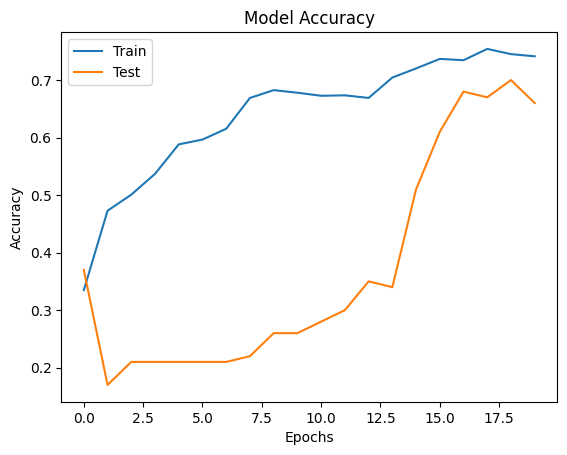

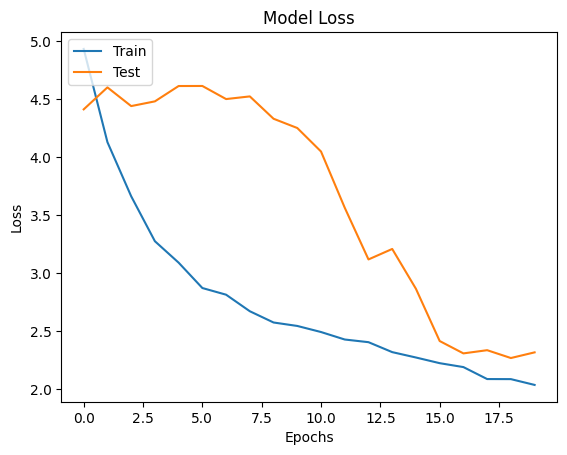

False


In [77]:
# Plot the training/validation accuracies/losses
plot(conv_3d6_1_model.history, conv_3d6_1.filepath)
# Save the model summary
save_summary(conv_3d6_1, conv_3d6_1_model, history_model14)

In [78]:
# Experimenting with BatchNormalization and Swipe activation function
# Model 15, frames_to_sample=30, batch_size=20, num_epochs=20, image_height=120, image_width=120
# Increasing the number of dense neurons to [256,128,5]
conv_3d6_2=ModelConv3D6()
conv_3d6_2.initialize_path(project_folder)
conv_3d6_2.initialize_image_properties(image_height=120,image_width=120)
conv_3d6_2.initialize_hyperparams(frames_to_sample=30,batch_size=20,num_epochs=20)
conv_3d6_2_model=conv_3d6_2.define_model("conv_3d6_2", filters=[8,16,32,64], dropout=[0.5,0.25], dense_neurons=[256,128,5])
print("Total Params:", conv_3d6_2_model.count_params())
conv_3d6_2_model.summary()

Total Params: 911973


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_72 (Conv3D)              │ (None, 30, 120, 120,   │           656 │
│                                 │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_104         │ (None, 30, 120, 120,   │            32 │
│ (BatchNormalization)            │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_72 (Activation)      │ (None, 30, 120, 120,   │             0 │
│                                 │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_72 (MaxPooling3D) │ (None, 15, 60, 60, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_73 (Conv3D)              │ (None, 15, 60, 60, 16) │         3,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_105         │ (None, 15, 60, 60, 16) │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_73 (Activation)      │ (None, 15, 60, 60, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_73 (MaxPooling3D) │ (None, 7, 30, 30, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_74 (Conv3D)              │ (None, 7, 30, 30, 32)  │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_106         │ (None, 7, 30, 30, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_74 (Activation)      │ (None, 7, 30, 30, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_74 (MaxPooling3D) │ (None, 3, 15, 15, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_75 (Conv3D)              │ (None, 3, 15, 15, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_107         │ (None, 3, 15, 15, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_75 (Activation)      │ (None, 3, 15, 15, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_75 (MaxPooling3D) │ (None, 1, 7, 7, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_18 (Flatten)            │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 256)            │       803,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_108         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 911,973 (3.48 MB)

 Trainable params: 910,965 (3.48 MB)

 Non-trainable params: 1,008 (3.94 KB)

In [79]:
# Show the total number of parameters and start the training
print("Total Params:", conv_3d6_2_model.count_params())
history_model15=conv_3d6_2.train_model(conv_3d6_2_model, augment_data=True)

Total Params: 911973
Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.3032 - loss: 8.3244
Epoch 1: val_loss improved from inf to 7.11834, saving model to model/model_init_2024-04-1521_50_14.194085/model-00001-7.88782-0.34766-7.11834-0.27000.h5.keras

Epoch 1: val_loss improved from inf to 7.11834, saving model to model/model_init_2024-04-1521_50_14.194085/model-00001-7.88782-0.34766-7.11834-0.27000.h5.weights.h5
34/34 ━━━━━━━━━━━━━━━━━━━━ 169s 5s/step - categorical_accuracy: 0.3044 - loss: 8.3120 - val_categorical_accuracy: 0.2700 - val_loss: 7.1183 - learning_rate: 0.0010
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.4643 - loss: 6.7099
Epoch 2: val_loss improved from 7.11834 to 6.49256, saving model to model/model_init_2024-04-1521_50_14.194085/model-00002-6.52761-0.46456-6.49256-0.28000.h5.keras

Epoch 2: val_loss improved from 7.11834 to 6.49256, saving model to model/model_init_2024-04-1521_50_14.194085/model-00002-6.52761-0.4

dict_keys(['categorical_accuracy', 'loss', 'val_categorical_accuracy', 'val_loss', 'learning_rate'])
0.34766215085983276 0.27000001072883606 7.88782262802124 7.118339538574219
0.8061839938163757 1.8426979780197144 0.6800000071525574 2.471207857131958 18


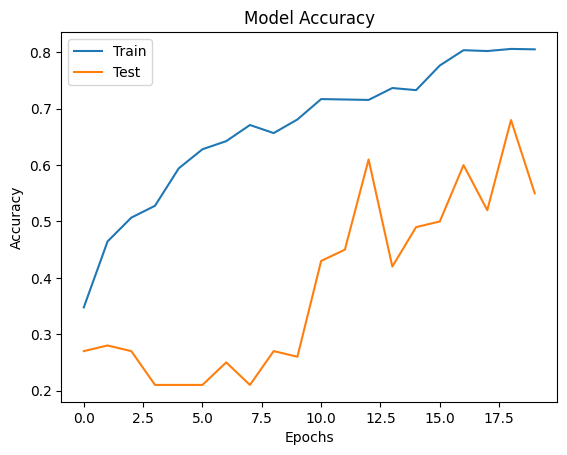

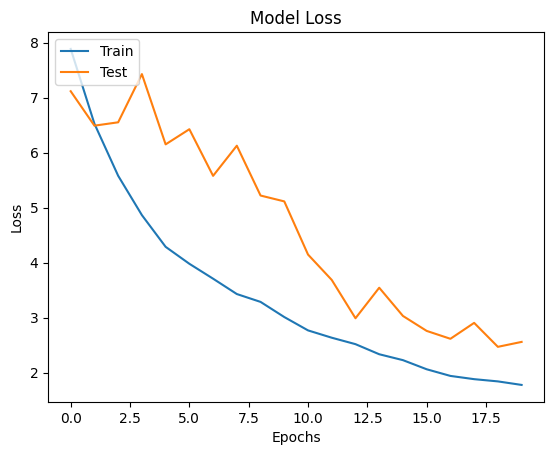

False


In [80]:
# Plot the training/validation accuracies/losses
plot(conv_3d6_2_model.history, conv_3d6_2.filepath)
# Save the model summary
save_summary(conv_3d6_2, conv_3d6_2_model, history_model15)

In [81]:
# Experimenting with BatchNormalization and Swipe activation function
# Model 16, frames_to_sample=16, batch_size=20, num_epochs=20, image_height=120, image_width=120
# Increasing the number of dense neurons to [256,128,5]
conv_3d6_3=ModelConv3D6()
conv_3d6_3.initialize_path(project_folder)
conv_3d6_3.initialize_image_properties(image_height=120,image_width=120)
conv_3d6_3.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=20)
conv_3d6_3_model=conv_3d6_3.define_model("conv_3d6_3", filters=[8,16,32,64], dropout=[0.5,0.25], dense_neurons=[256,128,5])
print("Total Params:", conv_3d6_3_model.count_params())
conv_3d6_3_model.summary()

Total Params: 911973


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_76 (Conv3D)              │ (None, 16, 120, 120,   │           656 │
│                                 │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_110         │ (None, 16, 120, 120,   │            32 │
│ (BatchNormalization)            │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_76 (Activation)      │ (None, 16, 120, 120,   │             0 │
│                                 │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_76 (MaxPooling3D) │ (None, 8, 60, 60, 8)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_77 (Conv3D)              │ (None, 8, 60, 60, 16)  │         3,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_111         │ (None, 8, 60, 60, 16)  │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_77 (Activation)      │ (None, 8, 60, 60, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_77 (MaxPooling3D) │ (None, 4, 30, 30, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_78 (Conv3D)              │ (None, 4, 30, 30, 32)  │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_112         │ (None, 4, 30, 30, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_78 (Activation)      │ (None, 4, 30, 30, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_78 (MaxPooling3D) │ (None, 2, 15, 15, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_79 (Conv3D)              │ (None, 2, 15, 15, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_113         │ (None, 2, 15, 15, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_79 (Activation)      │ (None, 2, 15, 15, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_79 (MaxPooling3D) │ (None, 1, 7, 7, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_19 (Flatten)            │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 256)            │       803,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_114         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 911,973 (3.48 MB)

 Trainable params: 910,965 (3.48 MB)

 Non-trainable params: 1,008 (3.94 KB)

In [82]:
# Show the total number of parameters and start the training
print("Total Params:", conv_3d6_3_model.count_params())
history_model16=conv_3d6_3.train_model(conv_3d6_3_model, augment_data=True)

Total Params: 911973
Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.3011 - loss: 8.1030
Epoch 1: val_loss improved from inf to 7.27392, saving model to model/model_init_2024-04-1522_37_01.717456/model-00001-7.69677-0.34917-7.27392-0.16000.h5.keras

Epoch 1: val_loss improved from inf to 7.27392, saving model to model/model_init_2024-04-1522_37_01.717456/model-00001-7.69677-0.34917-7.27392-0.16000.h5.weights.h5
34/34 ━━━━━━━━━━━━━━━━━━━━ 99s 3s/step - categorical_accuracy: 0.3025 - loss: 8.0914 - val_categorical_accuracy: 0.1600 - val_loss: 7.2739 - learning_rate: 0.0010
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.4494 - loss: 6.5666
Epoch 2: val_loss improved from 7.27392 to 6.77298, saving model to model/model_init_2024-04-1522_37_01.717456/model-00002-6.34443-0.46757-6.77298-0.15000.h5.keras

Epoch 2: val_loss improved from 7.27392 to 6.77298, saving model to model/model_init_2024-04-1522_37_01.717456/model-00002-6.34443-0.46

dict_keys(['categorical_accuracy', 'loss', 'val_categorical_accuracy', 'val_loss', 'learning_rate'])
0.349170446395874 0.1599999964237213 7.696767330169678 7.273921012878418
0.773001492023468 1.3101625442504883 0.6299999952316284 1.879132866859436 19


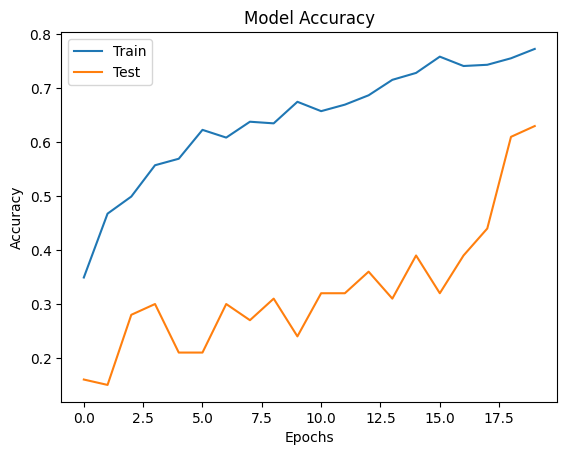

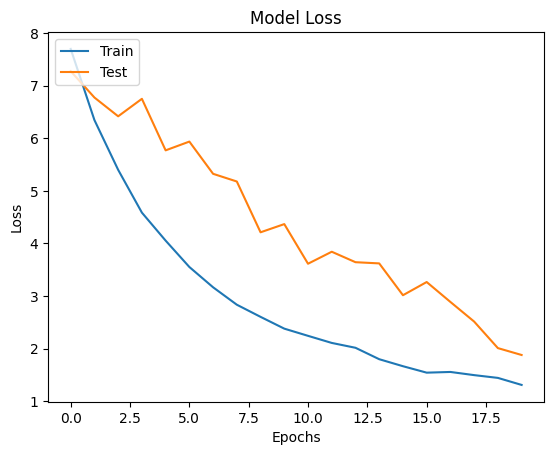

False


In [83]:
# Plot the training/validation accuracies/losses
plot(conv_3d6_3_model.history, conv_3d6_3.filepath)
# Save the model summary
save_summary(conv_3d6_3, conv_3d6_3_model, history_model16)

In [84]:
# Experimenting with BatchNormalization and Swipe activation function
# Model 17, frames_to_sample=16, batch_size=20, num_epochs=20, image_height=120, image_width=120
# Increasing the number of dense neurons to [256,128,5]
# Increasing dropout to [0.5, 0.5]
conv_3d6_4=ModelConv3D6()
conv_3d6_4.initialize_path(project_folder)
conv_3d6_4.initialize_image_properties(image_height=120,image_width=120)
conv_3d6_4.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=20)
conv_3d6_4_model=conv_3d6_4.define_model("conv_3d6_4", filters=[8,16,32,64], dropout=[0.5,0.5], dense_neurons=[256,128,5])
print("Total Params:", conv_3d6_4_model.count_params())
conv_3d6_4_model.summary()

Total Params: 911973


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_80 (Conv3D)              │ (None, 16, 120, 120,   │           656 │
│                                 │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_116         │ (None, 16, 120, 120,   │            32 │
│ (BatchNormalization)            │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_80 (Activation)      │ (None, 16, 120, 120,   │             0 │
│                                 │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_80 (MaxPooling3D) │ (None, 8, 60, 60, 8)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_81 (Conv3D)              │ (None, 8, 60, 60, 16)  │         3,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_117         │ (None, 8, 60, 60, 16)  │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_81 (Activation)      │ (None, 8, 60, 60, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_81 (MaxPooling3D) │ (None, 4, 30, 30, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_82 (Conv3D)              │ (None, 4, 30, 30, 32)  │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_118         │ (None, 4, 30, 30, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_82 (Activation)      │ (None, 4, 30, 30, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_82 (MaxPooling3D) │ (None, 2, 15, 15, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_83 (Conv3D)              │ (None, 2, 15, 15, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_119         │ (None, 2, 15, 15, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_83 (Activation)      │ (None, 2, 15, 15, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_83 (MaxPooling3D) │ (None, 1, 7, 7, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_20 (Flatten)            │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 256)            │       803,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_120         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 911,973 (3.48 MB)

 Trainable params: 910,965 (3.48 MB)

 Non-trainable params: 1,008 (3.94 KB)

In [85]:
# Show the total number of parameters and start the training
print("Total Params:", conv_3d6_4_model.count_params())
history_model17=conv_3d6_4.train_model(conv_3d6_4_model, augment_data=True)

Total Params: 911973
Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.2913 - loss: 8.4498
Epoch 1: val_loss improved from inf to 7.19729, saving model to model/model_init_2024-04-1523_42_41.721621/model-00001-7.98844-0.33937-7.19729-0.21000.h5.keras

Epoch 1: val_loss improved from inf to 7.19729, saving model to model/model_init_2024-04-1523_42_41.721621/model-00001-7.98844-0.33937-7.19729-0.21000.h5.weights.h5
34/34 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - categorical_accuracy: 0.2927 - loss: 8.4366 - val_categorical_accuracy: 0.2100 - val_loss: 7.1973 - learning_rate: 0.0010
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.4569 - loss: 6.9333
Epoch 2: val_loss improved from 7.19729 to 7.09878, saving model to model/model_init_2024-04-1523_42_41.721621/model-00002-6.80195-0.44570-7.09878-0.16000.h5.keras

Epoch 2: val_loss improved from 7.19729 to 7.09878, saving model to model/model_init_2024-04-1523_42_41.721621/model-00002-6.80195-0.44

dict_keys(['categorical_accuracy', 'loss', 'val_categorical_accuracy', 'val_loss', 'learning_rate'])
0.33936652541160583 0.20999999344348907 7.988435745239258 7.1972856521606445
0.7337858080863953 1.5762802362442017 0.5899999737739563 2.0993590354919434 19


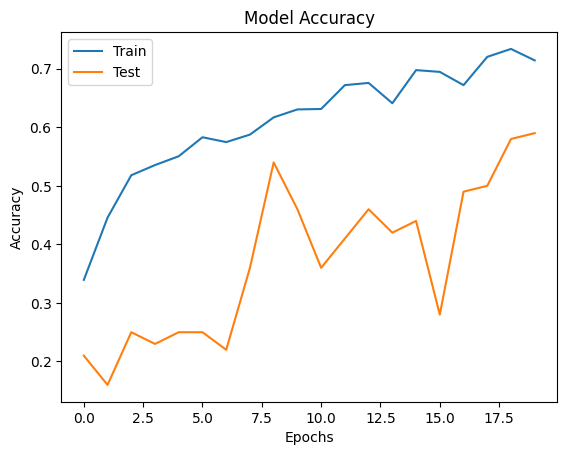

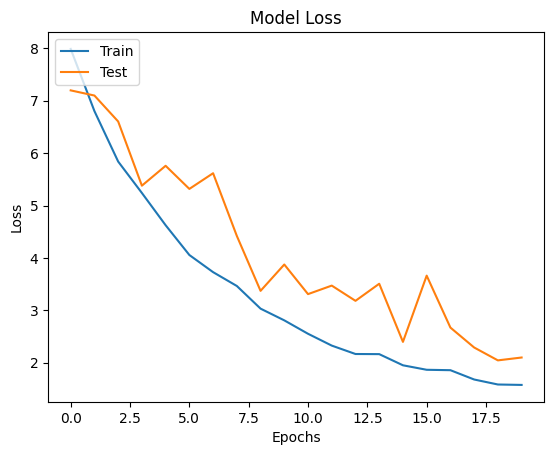

False


In [86]:
# Plot the training/validation accuracies/losses
plot(conv_3d6_4_model.history, conv_3d6_4.filepath)
# Save the model summary
save_summary(conv_3d6_4, conv_3d6_4_model, history_model17)

In [87]:

# Simple Model(Swipe activation function and batchnomal) with Adam optimizer and regularization L2 
# in experiment on different number of filters with ModelBuilder_2 with differennt kernal size
class ModelConv3D7(ModelBuilder_2):
    
    def define_model(self, name='model_conv3d_1', filters=[8,16,32,64], dropout=[0.5,0.25], dense_neurons=[128,64,5]):
        self.name = name
        model = Sequential()
        model.add(Conv3D(filters[0], (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Conv3D(filters[1], (3, 3, 3), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Conv3D(filters[2], (1, 3, 3), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Conv3D(filters[3], (1, 3, 3), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons[0],activation='relu', kernel_regularizer=l2(0.01)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout[0]))

        model.add(Dense(dense_neurons[1],activation='relu', kernel_regularizer=l2(0.01)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout[1]))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimizer = optimizers.Adam()
        
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model



In [88]:
# Experimenting with BatchNormalization and Swipe activation function with different kernal size
# Model 18, frames_to_sample=16, batch_size=20, num_epochs=20, image_height=120, image_width=120
# Increasing the number of dense neurons to [256,128,5]
# Increasing dropout to [0.5, 0.5]
conv_3d7_1=ModelConv3D7()
conv_3d7_1.initialize_path(project_folder)
conv_3d7_1.initialize_image_properties(image_height=120,image_width=120)
conv_3d7_1.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=20)
conv_3d7_1_model=conv_3d7_1.define_model("conv_3d7_1", filters=[8,16,32,64], dropout=[0.5,0.5], dense_neurons=[256,128,5])
print("Total Params:", conv_3d7_1_model.count_params())
conv_3d7_1_model.summary()


Total Params: 865893


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_84 (Conv3D)              │ (None, 16, 120, 120,   │           656 │
│                                 │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_122         │ (None, 16, 120, 120,   │            32 │
│ (BatchNormalization)            │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_84 (Activation)      │ (None, 16, 120, 120,   │             0 │
│                                 │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_84 (MaxPooling3D) │ (None, 8, 60, 60, 8)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_85 (Conv3D)              │ (None, 8, 60, 60, 16)  │         3,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_123         │ (None, 8, 60, 60, 16)  │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_85 (Activation)      │ (None, 8, 60, 60, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_85 (MaxPooling3D) │ (None, 4, 30, 30, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_86 (Conv3D)              │ (None, 4, 30, 30, 32)  │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_124         │ (None, 4, 30, 30, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_86 (Activation)      │ (None, 4, 30, 30, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_86 (MaxPooling3D) │ (None, 2, 15, 15, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_87 (Conv3D)              │ (None, 2, 15, 15, 64)  │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_125         │ (None, 2, 15, 15, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_87 (Activation)      │ (None, 2, 15, 15, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_87 (MaxPooling3D) │ (None, 1, 7, 7, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_21 (Flatten)            │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 256)            │       803,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_126         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 865,893 (3.30 MB)

 Trainable params: 864,885 (3.30 MB)

 Non-trainable params: 1,008 (3.94 KB)

In [89]:
# Show the total number of parameters and start the training
print("Total Params:", conv_3d7_1_model.count_params())
history_model18=conv_3d7_1.train_model(conv_3d7_1_model, augment_data=True)

Total Params: 865893
Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.2918 - loss: 8.5398
Epoch 1: val_loss improved from inf to 7.24028, saving model to model/model_init_2024-04-1600_11_45.537908/model-00001-8.14355-0.34238-7.24028-0.34000.h5.keras

Epoch 1: val_loss improved from inf to 7.24028, saving model to model/model_init_2024-04-1600_11_45.537908/model-00001-8.14355-0.34238-7.24028-0.34000.h5.weights.h5
34/34 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - categorical_accuracy: 0.2933 - loss: 8.5285 - val_categorical_accuracy: 0.3400 - val_loss: 7.2403 - learning_rate: 0.0010
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.4195 - loss: 7.2113
Epoch 2: val_loss improved from 7.24028 to 6.87996, saving model to model/model_init_2024-04-1600_11_45.537908/model-00002-7.14614-0.40196-6.87996-0.27000.h5.keras

Epoch 2: val_loss improved from 7.24028 to 6.87996, saving model to model/model_init_2024-04-1600_11_45.537908/model-00002-7.14614-0.40

dict_keys(['categorical_accuracy', 'loss', 'val_categorical_accuracy', 'val_loss', 'learning_rate'])
0.34238311648368835 0.3400000035762787 8.143553733825684 7.2402753829956055
0.7518853545188904 1.7211394309997559 0.6600000262260437 2.131438732147217 19


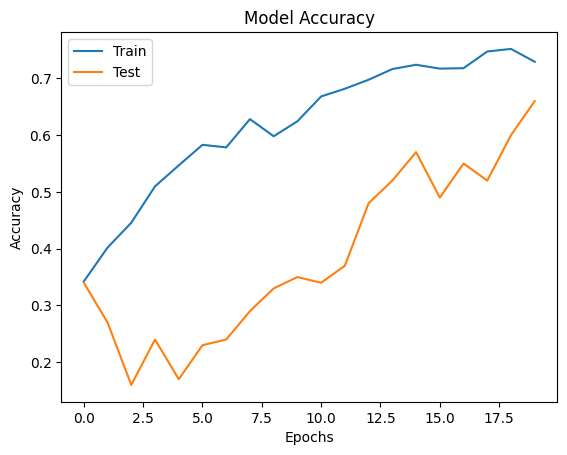

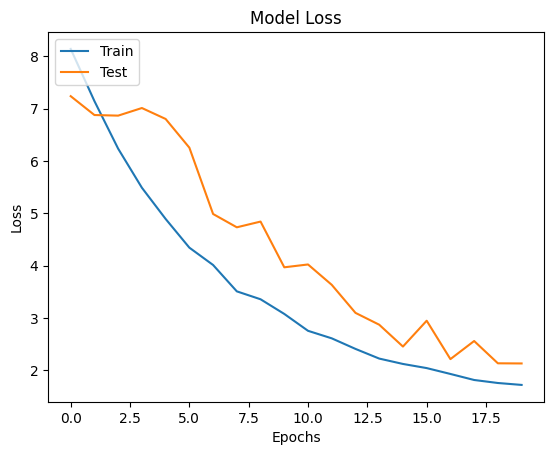

False


In [90]:
# Plot the training/validation accuracies/losses
plot(conv_3d7_1_model.history, conv_3d7_1.filepath)
# Save the model summary
save_summary(conv_3d7_1, conv_3d7_1_model, history_model18)

In [91]:
# The training accuracy has stablized and the validation accuracy has increased.

In [92]:

# Simple Model(Swipe activation function and batchnomal) with Adam optimizer and regularization L2 
# in experiment on different number of filters with ModelBuilder_2 with differennt kernal size + add dropout layer
class ModelConv3D8(ModelBuilder_2):
    
    def define_model(self, name='model_conv3d_1', filters=[8,16,32,64], dropout=[0.25,0.5,0.5], dense_neurons=[128,64,5]):
        self.name = name
        model = Sequential()
        model.add(Conv3D(filters[0], (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Conv3D(filters[1], (3, 3, 3), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Conv3D(filters[2], (1, 3, 3), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Conv3D(filters[3], (1, 3, 3), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(dropout[0]))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons[0],activation='relu', kernel_regularizer=l2(0.01)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout[1]))

        model.add(Dense(dense_neurons[1],activation='relu', kernel_regularizer=l2(0.01)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout[2]))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimizer = optimizers.Adam()
        
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model



In [93]:
# Experimenting with BatchNormalization and Swipe activation function with different kernal size
# Model 19, frames_to_sample=16, batch_size=20, num_epochs=20, image_height=120, image_width=120
# Increasing the number of dense neurons to [256,128,5]
# Increasing dropout to [0.25, 0.5, 0.5]
conv_3d8_1=ModelConv3D8()
conv_3d8_1.initialize_path(project_folder)
conv_3d8_1.initialize_image_properties(image_height=120,image_width=120)
conv_3d8_1.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=20)
conv_3d8_1_model=conv_3d8_1.define_model("conv_3d8_1", filters=[8,16,32,64], dropout=[0.25,0.5,0.5], dense_neurons=[256,128,5])
print("Total Params:", conv_3d8_1_model.count_params())
conv_3d8_1_model.summary()

Total Params: 865893


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_88 (Conv3D)              │ (None, 16, 120, 120,   │           656 │
│                                 │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_128         │ (None, 16, 120, 120,   │            32 │
│ (BatchNormalization)            │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_88 (Activation)      │ (None, 16, 120, 120,   │             0 │
│                                 │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_88 (MaxPooling3D) │ (None, 8, 60, 60, 8)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_89 (Conv3D)              │ (None, 8, 60, 60, 16)  │         3,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_129         │ (None, 8, 60, 60, 16)  │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_89 (Activation)      │ (None, 8, 60, 60, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_89 (MaxPooling3D) │ (None, 4, 30, 30, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_90 (Conv3D)              │ (None, 4, 30, 30, 32)  │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_130         │ (None, 4, 30, 30, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_90 (Activation)      │ (None, 4, 30, 30, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_90 (MaxPooling3D) │ (None, 2, 15, 15, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_91 (Conv3D)              │ (None, 2, 15, 15, 64)  │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_131         │ (None, 2, 15, 15, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_91 (Activation)      │ (None, 2, 15, 15, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 2, 15, 15, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_91 (MaxPooling3D) │ (None, 1, 7, 7, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_22 (Flatten)            │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 256)            │       803,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_132         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 865,893 (3.30 MB)

 Trainable params: 864,885 (3.30 MB)

 Non-trainable params: 1,008 (3.94 KB)

In [94]:
# Show the total number of parameters and start the training
print("Total Params:", conv_3d8_1_model.count_params())
history_model19=conv_3d8_1.train_model(conv_3d8_1_model, augment_data=True)

Total Params: 865893
Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.3150 - loss: 8.4399
Epoch 1: val_loss improved from inf to 7.80964, saving model to model/model_init_2024-04-1600_43_58.726685/model-00001-8.17084-0.33409-7.80964-0.16000.h5.keras

Epoch 1: val_loss improved from inf to 7.80964, saving model to model/model_init_2024-04-1600_43_58.726685/model-00001-8.17084-0.33409-7.80964-0.16000.h5.weights.h5
34/34 ━━━━━━━━━━━━━━━━━━━━ 100s 3s/step - categorical_accuracy: 0.3155 - loss: 8.4322 - val_categorical_accuracy: 0.1600 - val_loss: 7.8096 - learning_rate: 0.0010
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.4012 - loss: 7.1915
Epoch 2: val_loss did not improve from 7.80964

Epoch 2: val_loss did not improve from 7.80964
34/34 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step - categorical_accuracy: 0.4012 - loss: 7.1858 - val_categorical_accuracy: 0.2700 - val_loss: 7.8183 - learning_rate: 0.0010
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 

dict_keys(['categorical_accuracy', 'loss', 'val_categorical_accuracy', 'val_loss', 'learning_rate'])
0.3340874910354614 0.1599999964237213 8.170836448669434 7.809643745422363
0.7978883981704712 2.5586671829223633 0.3400000035762787 3.36078143119812 11


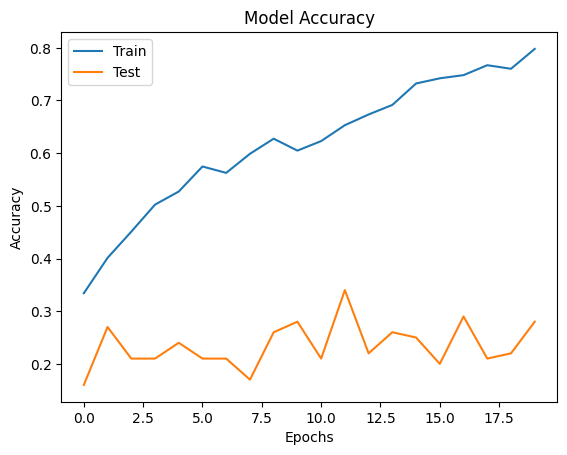

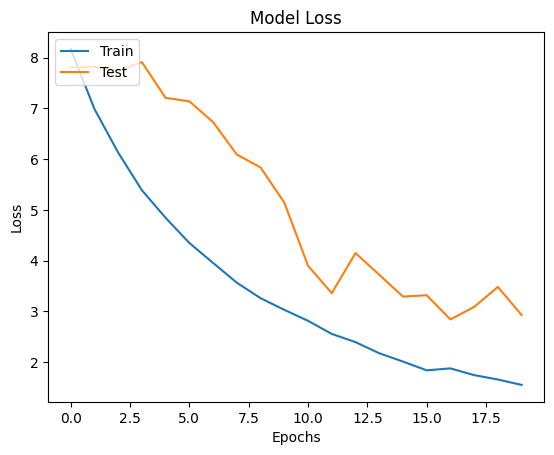

False


In [95]:
# Plot the training/validation accuracies/losses
plot(conv_3d8_1_model.history, conv_3d8_1.filepath)
# Save the model summary
save_summary(conv_3d8_1, conv_3d8_1_model, history_model19)

In [ ]:
# The conv_3d8 model result is not as expected. The training accuracy has increased but the validation accuracy has not increased.

In [12]:
# With rotaion augment and RGB

class ModelBuilder_3(metaclass= abc.ABCMeta):
    # initialisng the path where project data resides
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)

    # initialising the image properties    
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
        

    # initialising the batch size, frames to sample and the no. of epochs
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
    # MOST IMPORTANT PART HERE - The generator function        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
   
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx):
                #performing image reading and resizing
                image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                #image_resized=imresize(image,(self.image_height,self.image_width,3))
                image_resized = crop_resize_img(image,self.image_width,self.image_height)
                # image_resized = cv2.resize(image, (self.image_width,self.image_height), interpolation = cv2.INTER_AREA)

                #normalizing the images
                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    # Randomly shifting the image to the left or right
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    
                    
                    rgb = cv2.cvtColor(shifted,cv2.COLOR_BGR2RGB)
                    
                    # x0, y0 = np.argwhere(rgb > 0).min(axis=0)
                    # x1, y1 = np.argwhere(rgb > 0).max(axis=0) 
                    # cropping the images to have the targeted gestures and remove the noise from the images.
                    # cropped=shifted[x0:x1,y0:y1,:]
                    
                    # image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    image_resized = crop_resize_img(rgb, self.image_width, self.image_height)
                    # image_resized = cv2.resize(cropped, (self.image_width,self.image_height), interpolation = cv2.INTER_AREA)

                    M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))

                    batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        start_time = time.perf_counter()
                
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        if not os.path.exists('model'):
            os.mkdir('model')

        model_name = 'model/' + self.name + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
        self.filepath = filepath

        checkpoint = ModelCheckpoint(filepath + '.keras', monitor='val_loss', verbose=1, save_freq='epoch', save_best_only=True, save_weights_only=False, mode='auto')
        checkpoint_h5 = ModelCheckpoint(filepath + '.weights.h5', monitor='val_loss', verbose=1, save_freq='epoch', save_best_only=True, save_weights_only=True, mode='auto')
        
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)
        earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
        
        logdir = "logs/scalars/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = TensorBoard(log_dir=logdir)
        csv_logger = CSVLogger(f'{filepath}.log')

        callbacks_list = [checkpoint, checkpoint_h5, LR, earlystop, tensorboard_callback, csv_logger]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        # history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
        #                     callbacks=callbacks_list, validation_data=val_generator, 
        #                     validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, initial_epoch=0)
        end_time = time.perf_counter()
        self.total_time = end_time - start_time
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass
    
    

In [14]:
# Do another data Augmentation with ModelBuilder_3
# Simple Model (ModelConv3D6) with Adam optimizer and regularization L2 in experiment on different number of filters


# Simple Model(Swipe activation function and batchnomal) with Adam optimizer and regularization L2 
# in experiment on different number of filters with ModelBuilder_2 with differennt kernal size + add dropout layer
class ModelConv3D9(ModelBuilder_3):
    
    def define_model(self, name='model_conv3d_1', filters=[8,16,32,64], dropout=[0.5,0.25], dense_neurons=[128,64,5]):
        self.name = name
        model = Sequential()
        model.add(Conv3D(filters[0], (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Conv3D(filters[1], (3, 3, 3), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Conv3D(filters[2], (3, 3, 3), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Conv3D(filters[3], (3, 3, 3), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons[0],activation='relu', kernel_regularizer=l2(0.01)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout[0]))

        model.add(Dense(dense_neurons[1],activation='relu', kernel_regularizer=l2(0.01)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout[1]))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimizer = optimizers.Adam()
        
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model



In [23]:
# Experimenting with BatchNormalization and Swipe activation function with different kernal size
# Model 20, frames_to_sample=16, batch_size=20, num_epochs=30, image_height=120, image_width=120
# Increasing the number of dense neurons to [256,128,5]
# Increasing dropout to [0.25, 0.5, 0.5]
conv_3d9_1=ModelConv3D9()
conv_3d9_1.initialize_path(project_folder)
conv_3d9_1.initialize_image_properties(image_height=120,image_width=120)
conv_3d9_1.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d9_1_model=conv_3d9_1.define_model("conv_3d9_1", filters=[16,32,64,128], dropout=[0.25,0.5,0.5], dense_neurons=[256,128,5])
print("Total Params:", conv_3d9_1_model.count_params())
conv_3d9_1_model.summary()

Total Params: 1933765


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_8 (Conv3D)               │ (None, 16, 120, 120,   │         1,312 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 16, 120, 120,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 16, 120, 120,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_8 (MaxPooling3D)  │ (None, 8, 60, 60, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_9 (Conv3D)               │ (None, 8, 60, 60, 32)  │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 8, 60, 60, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 8, 60, 60, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_9 (MaxPooling3D)  │ (None, 4, 30, 30, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_10 (Conv3D)              │ (None, 4, 30, 30, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 4, 30, 30, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 4, 30, 30, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_10 (MaxPooling3D) │ (None, 2, 15, 15, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_11 (Conv3D)              │ (None, 2, 15, 15, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 2, 15, 15, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 2, 15, 15, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_11 (MaxPooling3D) │ (None, 1, 7, 7, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     1,605,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,933,765 (7.38 MB)

 Trainable params: 1,932,517 (7.37 MB)

 Non-trainable params: 1,248 (4.88 KB)

In [24]:
# Show the total number of parameters and start the training
print("Total Params:", conv_3d9_1_model.count_params())
history_model20=conv_3d9_1.train_model(conv_3d9_1_model, augment_data=True)

Total Params: 1933765
Epoch 1/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.3293 - loss: 8.4753
Epoch 1: val_loss improved from inf to 8.03692, saving model to model/model_init_2024-04-1602_39_31.457249/model-00001-8.01688-0.35596-8.03692-0.19000.h5.keras

Epoch 1: val_loss improved from inf to 8.03692, saving model to model/model_init_2024-04-1602_39_31.457249/model-00001-8.01688-0.35596-8.03692-0.19000.h5.weights.h5
34/34 ━━━━━━━━━━━━━━━━━━━━ 92s 3s/step - categorical_accuracy: 0.3301 - loss: 8.4622 - val_categorical_accuracy: 0.1900 - val_loss: 8.0369 - learning_rate: 0.0010
Epoch 2/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.4390 - loss: 6.7692
Epoch 2: val_loss improved from 8.03692 to 6.24797, saving model to model/model_init_2024-04-1602_39_31.457249/model-00002-6.48720-0.43590-6.24797-0.30000.h5.keras

Epoch 2: val_loss improved from 8.03692 to 6.24797, saving model to model/model_init_2024-04-1602_39_31.457249/model-00002-6.48720-0.4

dict_keys(['categorical_accuracy', 'loss', 'val_categorical_accuracy', 'val_loss', 'learning_rate'])
0.3559577763080597 0.1899999976158142 8.01688289642334 8.036924362182617
0.7473604679107666 2.265291690826416 0.6800000071525574 2.40848970413208 29


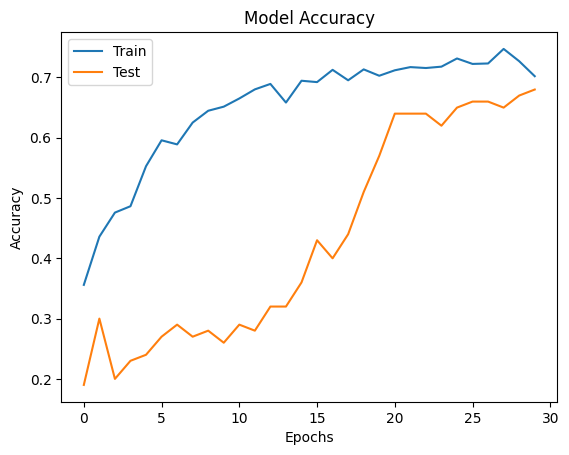

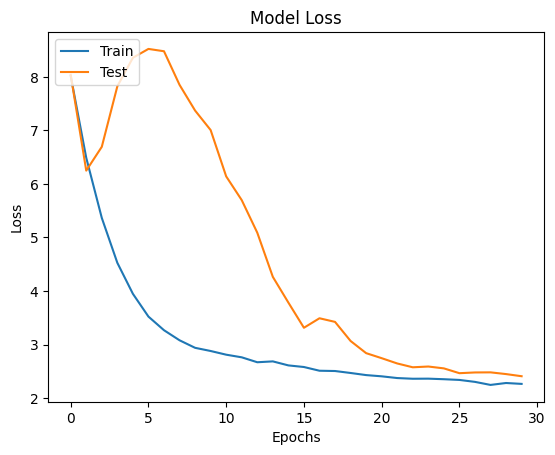

False


In [27]:
# Plot the training/validation accuracies/losses
plot(conv_3d9_1_model.history, conv_3d9_1)
# Save the model summary
save_summary(conv_3d9_1, conv_3d9_1_model, history_model20)

In [28]:
# Experimenting with BatchNormalization and Swipe activation function with different kernal size
# Model 21, frames_to_sample=16, batch_size=20, num_epochs=20, image_height=120, image_width=120
# Increasing the number of dense neurons to [256,128,5]
# dropout: [0.5, 0.25]
conv_3d9_2=ModelConv3D9()
conv_3d9_2.initialize_path(project_folder)
conv_3d9_2.initialize_image_properties(image_height=120,image_width=120)
conv_3d9_2.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=20)
conv_3d9_2_model=conv_3d9_2.define_model("conv_3d9_2", filters=[16,32,64,128], dropout=[0.5,0.25], dense_neurons=[256,128,5])
print("Total Params:", conv_3d9_2_model.count_params())
conv_3d9_2_model.summary()

Total Params: 1933765


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_12 (Conv3D)              │ (None, 16, 120, 120,   │         1,312 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 16, 120, 120,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 16, 120, 120,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_12 (MaxPooling3D) │ (None, 8, 60, 60, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_13 (Conv3D)              │ (None, 8, 60, 60, 32)  │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 8, 60, 60, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 8, 60, 60, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_13 (MaxPooling3D) │ (None, 4, 30, 30, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_14 (Conv3D)              │ (None, 4, 30, 30, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 4, 30, 30, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 4, 30, 30, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_14 (MaxPooling3D) │ (None, 2, 15, 15, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_15 (Conv3D)              │ (None, 2, 15, 15, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 2, 15, 15, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 2, 15, 15, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_15 (MaxPooling3D) │ (None, 1, 7, 7, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │     1,605,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,933,765 (7.38 MB)

 Trainable params: 1,932,517 (7.37 MB)

 Non-trainable params: 1,248 (4.88 KB)

In [29]:
# Show the total number of parameters and start the training
print("Total Params:", conv_3d9_2_model.count_params())
history_model21=conv_3d9_2.train_model(conv_3d9_2_model, augment_data=True)

Total Params: 1933765
Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.3425 - loss: 8.2040
Epoch 1: val_loss improved from inf to 8.73668, saving model to model/model_init_2024-04-1603_27_53.151955/model-00001-7.73723-0.40045-8.73668-0.21000.h5.keras

Epoch 1: val_loss improved from inf to 8.73668, saving model to model/model_init_2024-04-1603_27_53.151955/model-00001-7.73723-0.40045-8.73668-0.21000.h5.weights.h5
34/34 ━━━━━━━━━━━━━━━━━━━━ 90s 3s/step - categorical_accuracy: 0.3442 - loss: 8.1906 - val_categorical_accuracy: 0.2100 - val_loss: 8.7367 - learning_rate: 0.0010
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.4762 - loss: 6.5840
Epoch 2: val_loss improved from 8.73668 to 6.05606, saving model to model/model_init_2024-04-1603_27_53.151955/model-00002-6.21393-0.50075-6.05606-0.34000.h5.keras

Epoch 2: val_loss improved from 8.73668 to 6.05606, saving model to model/model_init_2024-04-1603_27_53.151955/model-00002-6.21393-0.5

dict_keys(['categorical_accuracy', 'loss', 'val_categorical_accuracy', 'val_loss', 'learning_rate'])
0.40045249462127686 0.20999999344348907 7.737234592437744 8.736684799194336
0.7745097875595093 1.749734878540039 0.5699999928474426 2.3235321044921875 19


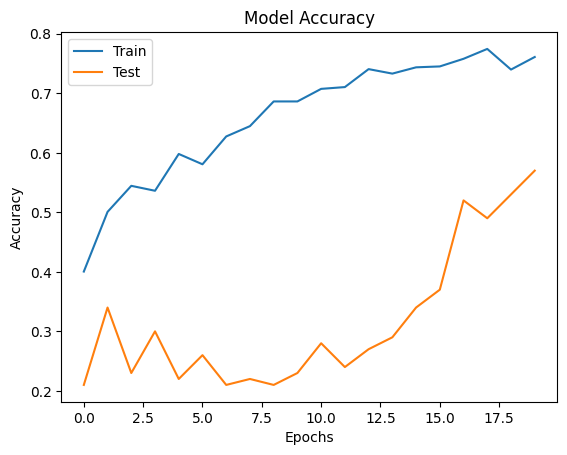

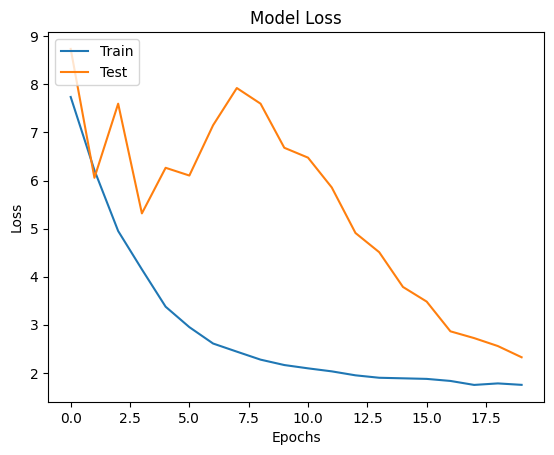

False


In [30]:
# Plot the training/validation accuracies/losses
plot(conv_3d9_2_model.history, conv_3d9_2)
# Save the model summary
save_summary(conv_3d9_2, conv_3d9_2_model, history_model21)

In [31]:
# Experimenting with BatchNormalization and Swipe activation function with different kernal size
# Model 21, frames_to_sample=16, batch_size=20, num_epochs=20, image_height=120, image_width=120
# dense neurons to [128,64,5]
# dropout: [0.5, 0.25]
conv_3d9_3=ModelConv3D9()
conv_3d9_3.initialize_path(project_folder)
conv_3d9_3.initialize_image_properties(image_height=120,image_width=120)
conv_3d9_3.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=20)
conv_3d9_3_model=conv_3d9_3.define_model("conv_3d9_3", filters=[16,32,64,128], dropout=[0.5,0.25], dense_neurons=[128,64,5])
print("Total Params:", conv_3d9_3_model.count_params())
conv_3d9_3_model.summary()

Total Params: 1105093


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_16 (Conv3D)              │ (None, 16, 120, 120,   │         1,312 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 16, 120, 120,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 16, 120, 120,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_16 (MaxPooling3D) │ (None, 8, 60, 60, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_17 (Conv3D)              │ (None, 8, 60, 60, 32)  │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 8, 60, 60, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 8, 60, 60, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_17 (MaxPooling3D) │ (None, 4, 30, 30, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_18 (Conv3D)              │ (None, 4, 30, 30, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 4, 30, 30, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_18 (Activation)      │ (None, 4, 30, 30, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_18 (MaxPooling3D) │ (None, 2, 15, 15, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_19 (Conv3D)              │ (None, 2, 15, 15, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 2, 15, 15, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_19 (Activation)      │ (None, 2, 15, 15, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_19 (MaxPooling3D) │ (None, 1, 7, 7, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,105,093 (4.22 MB)

 Trainable params: 1,104,229 (4.21 MB)

 Non-trainable params: 864 (3.38 KB)

In [32]:
# Show the total number of parameters and start the training
print("Total Params:", conv_3d9_3_model.count_params())
history_model22=conv_3d9_3.train_model(conv_3d9_3_model, augment_data=True)

Total Params: 1105093
Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.3098 - loss: 5.0951
Epoch 1: val_loss improved from inf to 4.49980, saving model to model/model_init_2024-04-1603_53_40.236643/model-00001-4.82942-0.36878-4.49980-0.24000.h5.keras

Epoch 1: val_loss improved from inf to 4.49980, saving model to model/model_init_2024-04-1603_53_40.236643/model-00001-4.82942-0.36878-4.49980-0.24000.h5.weights.h5
34/34 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - categorical_accuracy: 0.3115 - loss: 5.0875 - val_categorical_accuracy: 0.2400 - val_loss: 4.4998 - learning_rate: 0.0010
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.4084 - loss: 4.1640
Epoch 2: val_loss improved from 4.49980 to 4.39174, saving model to model/model_init_2024-04-1603_53_40.236643/model-00002-3.99160-0.44646-4.39174-0.33000.h5.keras

Epoch 2: val_loss improved from 4.49980 to 4.39174, saving model to model/model_init_2024-04-1603_53_40.236643/model-00002-3.99160-0.4

dict_keys(['categorical_accuracy', 'loss', 'val_categorical_accuracy', 'val_loss', 'learning_rate'])
0.3687782883644104 0.23999999463558197 4.829416751861572 4.499800205230713
0.6870286464691162 3.991603136062622 0.33000001311302185 4.391741752624512 1


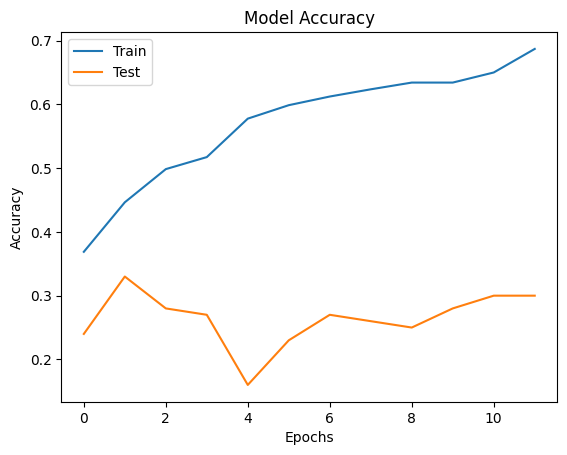

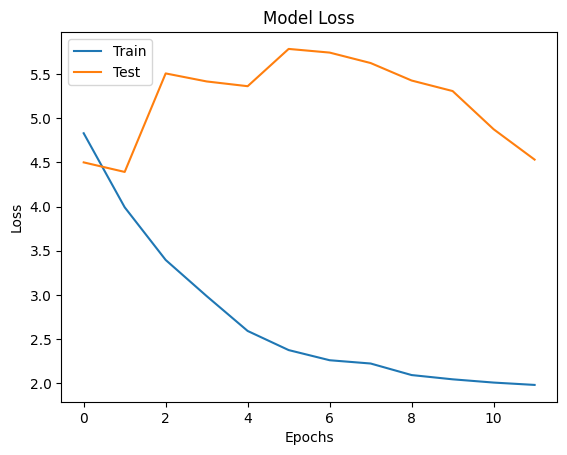

False


In [33]:
# Plot the training/validation accuracies/losses
plot(conv_3d9_3_model.history, conv_3d9_3)
# Save the model summary
save_summary(conv_3d9_3, conv_3d9_3_model, history_model22)

In [38]:
# Run Model 5 again


# Do more data Augmentation with ModelBuilder_2
# Simple Model with Adam optimizer and regularization L2 in experiment on different number of filters
class TestModelConv3D5(ModelBuilder_2):
    
    def define_model(self, name='model_conv3d_1', filters=[8,16,32,64], dropout=[0.5,0.25], dense_neurons=[128,64,5]):
        self.name = name
        model = Sequential()
        model.add(Conv3D(filters[0], (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Conv3D(filters[1], (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Conv3D(filters[2], (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Conv3D(filters[3], (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons[0],activation='relu', kernel_regularizer=l2(0.01)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout[0]))

        model.add(Dense(dense_neurons[1],activation='relu', kernel_regularizer=l2(0.01)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout[1]))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimizer = optimizers.Adam()
        
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model


In [39]:

conv_3d5_1_test=TestModelConv3D5()
conv_3d5_1_test.initialize_path(project_folder)
conv_3d5_1_test.initialize_image_properties(image_height=120,image_width=120)
conv_3d5_1_test.initialize_hyperparams(frames_to_sample=30,batch_size=20,num_epochs=20)
conv_3d5_1_test_model=conv_3d5_1_test.define_model("test_conv_3d5_1", filters=[8,16,32,64], dropout=[0.5,0.25], dense_neurons=[128,64,5])
conv_3d5_1_test_model.summary()



Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_24 (Conv3D)              │ (None, 30, 120, 120,   │           656 │
│                                 │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_24 (Activation)      │ (None, 30, 120, 120,   │             0 │
│                                 │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 30, 120, 120,   │            32 │
│ (BatchNormalization)            │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_24 (MaxPooling3D) │ (None, 15, 60, 60, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_25 (Conv3D)              │ (None, 15, 60, 60, 16) │         3,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_25 (Activation)      │ (None, 15, 60, 60, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 15, 60, 60, 16) │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_25 (MaxPooling3D) │ (None, 7, 30, 30, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_26 (Conv3D)              │ (None, 7, 30, 30, 32)  │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_26 (Activation)      │ (None, 7, 30, 30, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 7, 30, 30, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_26 (MaxPooling3D) │ (None, 3, 15, 15, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_27 (Conv3D)              │ (None, 3, 15, 15, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_27 (Activation)      │ (None, 3, 15, 15, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 3, 15, 15, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_27 (MaxPooling3D) │ (None, 1, 7, 7, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 484,709 (1.85 MB)

 Trainable params: 484,085 (1.85 MB)

 Non-trainable params: 624 (2.44 KB)

In [40]:
print("Total Params:", conv_3d5_1_test_model.count_params())
history_model5_test=conv_3d5_1_test.train_model(conv_3d5_1_test_model, augment_data=True)

Total Params: 484709
Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.3053 - loss: 5.1964
Epoch 1: val_loss improved from inf to 4.67178, saving model to model/model_init_2024-04-1609_46_00.471068/model-00001-4.98150-0.35897-4.67178-0.22000.h5.keras

Epoch 1: val_loss improved from inf to 4.67178, saving model to model/model_init_2024-04-1609_46_00.471068/model-00001-4.98150-0.35897-4.67178-0.22000.h5.weights.h5
34/34 ━━━━━━━━━━━━━━━━━━━━ 164s 5s/step - categorical_accuracy: 0.3068 - loss: 5.1903 - val_categorical_accuracy: 0.2200 - val_loss: 4.6718 - learning_rate: 0.0010
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.4616 - loss: 4.4186
Epoch 2: val_loss improved from 4.67178 to 4.66137, saving model to model/model_init_2024-04-1609_46_00.471068/model-00002-4.37870-0.44118-4.66137-0.16000.h5.keras

Epoch 2: val_loss improved from 4.67178 to 4.66137, saving model to model/model_init_2024-04-1609_46_00.471068/model-00002-4.37870-0.4

dict_keys(['categorical_accuracy', 'loss', 'val_categorical_accuracy', 'val_loss', 'learning_rate'])
0.3589743673801422 0.2199999988079071 4.981503486633301 4.671779632568359
0.8288084268569946 1.4462890625 0.6700000166893005 1.7547842264175415 19


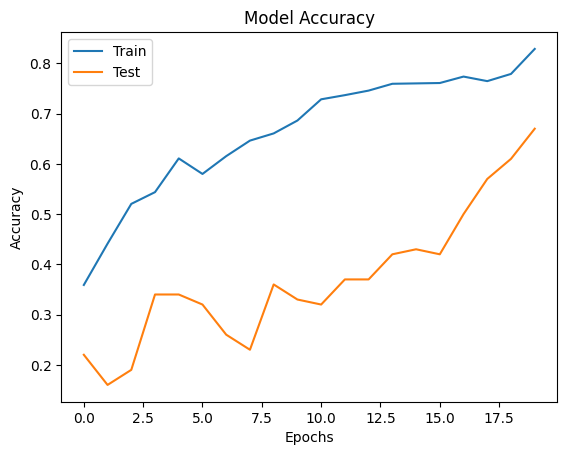

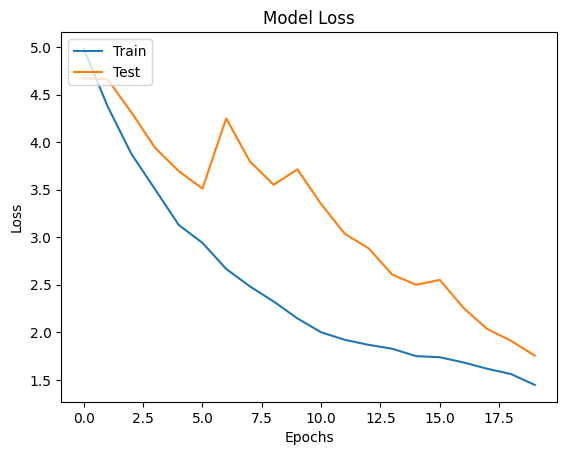

False


In [41]:
plot(conv_3d5_1_test_model.history, conv_3d5_1_test)
save_summary(conv_3d5_1_test, conv_3d5_1_test_model, history_model5_test)

In [42]:
# Run Model 5 with ModelBuilder_3 (RGB)

# Simple Model with Adam optimizer and regularization L2 in experiment on different number of filters
class TestModelConv3D5_mb3(ModelBuilder_3):
    
    def define_model(self, name='model_conv3d_1', filters=[8,16,32,64], dropout=[0.5,0.25], dense_neurons=[128,64,5]):
        self.name = name
        model = Sequential()
        model.add(Conv3D(filters[0], (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Conv3D(filters[1], (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Conv3D(filters[2], (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Conv3D(filters[3], (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons[0],activation='relu', kernel_regularizer=l2(0.01)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout[0]))

        model.add(Dense(dense_neurons[1],activation='relu', kernel_regularizer=l2(0.01)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout[1]))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimizer = optimizers.Adam()
        
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model


In [43]:
# Experimenting Conv3D5 with ModelBuilder_3
conv_3d5_1_test_mb3=TestModelConv3D5_mb3()
conv_3d5_1_test_mb3.initialize_path(project_folder)
conv_3d5_1_test_mb3.initialize_image_properties(image_height=120,image_width=120)
conv_3d5_1_test_mb3.initialize_hyperparams(frames_to_sample=30,batch_size=20,num_epochs=20)
conv_3d5_1_test_mb3_model=conv_3d5_1_test_mb3.define_model("test_conv_3d5_1", filters=[8,16,32,64], dropout=[0.5,0.25], dense_neurons=[128,64,5])
print("Total Params:", conv_3d5_1_test_mb3_model.count_params())
conv_3d5_1_test_mb3_model.summary()

Total Params: 484709


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_28 (Conv3D)              │ (None, 30, 120, 120,   │           656 │
│                                 │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_28 (Activation)      │ (None, 30, 120, 120,   │             0 │
│                                 │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 30, 120, 120,   │            32 │
│ (BatchNormalization)            │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_28 (MaxPooling3D) │ (None, 15, 60, 60, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_29 (Conv3D)              │ (None, 15, 60, 60, 16) │         3,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_29 (Activation)      │ (None, 15, 60, 60, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 15, 60, 60, 16) │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_29 (MaxPooling3D) │ (None, 7, 30, 30, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_30 (Conv3D)              │ (None, 7, 30, 30, 32)  │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_30 (Activation)      │ (None, 7, 30, 30, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ (None, 7, 30, 30, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_30 (MaxPooling3D) │ (None, 3, 15, 15, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_31 (Conv3D)              │ (None, 3, 15, 15, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_31 (Activation)      │ (None, 3, 15, 15, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_45          │ (None, 3, 15, 15, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_31 (MaxPooling3D) │ (None, 1, 7, 7, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_46          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 484,709 (1.85 MB)

 Trainable params: 484,085 (1.85 MB)

 Non-trainable params: 624 (2.44 KB)

In [44]:
# Show the total number of parameters and start the training
print("Total Params:", conv_3d5_1_test_mb3_model.count_params())
history_model5_test_mb3=conv_3d5_1_test_mb3.train_model(conv_3d5_1_test_mb3_model, augment_data=True)

Total Params: 484709
Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.2895 - loss: 5.2509
Epoch 1: val_loss improved from inf to 4.85144, saving model to model/model_init_2024-04-1616_09_41.729088/model-00001-5.03641-0.33258-4.85144-0.24000.h5.keras

Epoch 1: val_loss improved from inf to 4.85144, saving model to model/model_init_2024-04-1616_09_41.729088/model-00001-5.03641-0.33258-4.85144-0.24000.h5.weights.h5
34/34 ━━━━━━━━━━━━━━━━━━━━ 158s 5s/step - categorical_accuracy: 0.2908 - loss: 5.2448 - val_categorical_accuracy: 0.2400 - val_loss: 4.8514 - learning_rate: 0.0010
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.4350 - loss: 4.5007
Epoch 2: val_loss improved from 4.85144 to 4.83783, saving model to model/model_init_2024-04-1616_09_41.729088/model-00002-4.36482-0.44570-4.83783-0.28000.h5.keras

Epoch 2: val_loss improved from 4.85144 to 4.83783, saving model to model/model_init_2024-04-1616_09_41.729088/model-00002-4.36482-0.4

dict_keys(['categorical_accuracy', 'loss', 'val_categorical_accuracy', 'val_loss', 'learning_rate'])
0.33257919549942017 0.23999999463558197 5.036410808563232 4.851439476013184
0.7541478276252747 1.3577632904052734 0.7200000286102295 1.6401296854019165 19


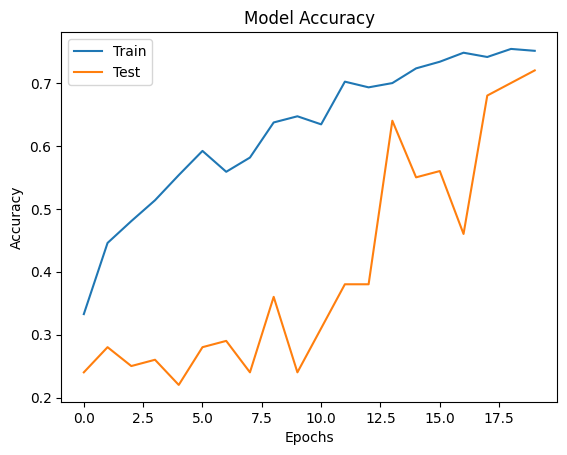

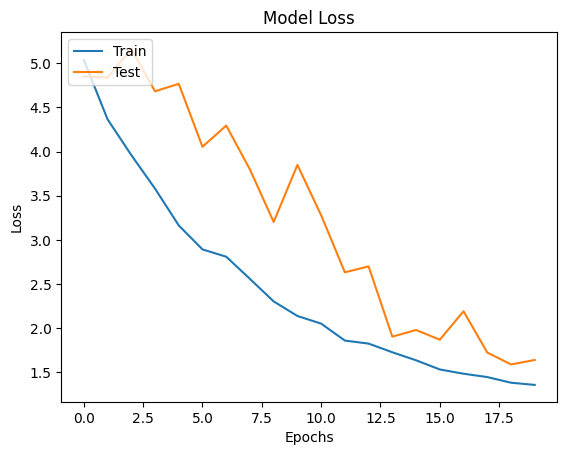

False


In [45]:
# Plot the training/validation accuracies/losses
plot(conv_3d5_1_test_mb3_model.history, conv_3d5_1_test_mb3)
# Save the model summary
save_summary(conv_3d5_1_test_mb3, conv_3d5_1_test_mb3_model, history_model5_test_mb3)

In [3]:
%tensorboard --logdir logs/scalars

Reusing TensorBoard on port 6006 (pid 3438457), started 1 day, 7:35:58 ago. (Use '!kill 3438457' to kill it.)

#### CNN-RNN - Convolutional Neural Network with Recurrent Neural Network

###### CNN-GRU Model

In [47]:
# Sample CNN-GRU Model

class Model_CNN_RNN_1(ModelBuilder_3):
    def define_model(self, name="cnn_rnn_1", filters=[16,32,64], cells=[64], dense_neurons=[64], dropout=[0.25,0.25]):
        self.name = name
        with tf.device('/device:GPU:0'):
            model= Sequential()

            model.add(TimeDistributed(Conv2D(filters[0], kernel_size=(3, 3),  padding='same'),input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
            model.add(TimeDistributed(Activation('relu')))
            model.add(TimeDistributed(BatchNormalization()))


            model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

            model.add(TimeDistributed(Conv2D(filters[1], kernel_size=(3, 3), padding='same')))
            model.add(TimeDistributed(Activation('relu')))
            model.add(TimeDistributed(BatchNormalization()))


            model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

            model.add(TimeDistributed(Conv2D(filters[2], kernel_size=(3, 3),  padding='same')))
            model.add(TimeDistributed(Activation('relu')))
            model.add(TimeDistributed(BatchNormalization()))


            model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

            model.add(TimeDistributed(Flatten()))

            model.add(GRU(cells[0]))
            model.add(Dropout(dropout[0]))

            model.add(Dense(dense_neurons[0], activation='relu'))
            model.add(Dropout(dropout[0]))

            model.add(Dense(self.num_classes, activation='softmax'))


            optimiser = optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
            model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

        return model



In [50]:
# Experimenting with CNN + GRU
# Model 23, frames_to_sample=20, batch_size=64, num_epochs=20, image_height=120, image_width=120
# filters=[8,16,32], cells=[64], dense_neurons=[64], dropout=[0.25,0.25]
cnn_rnn_1 = Model_CNN_RNN_1()
cnn_rnn_1.initialize_path(project_folder)
cnn_rnn_1.initialize_image_properties(image_height=120,image_width=120)
cnn_rnn_1.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=20)
cnn_rnn_1_model=cnn_rnn_1.define_model("cnn_rnn_1", filters=[8,16,32], cells=[64], dense_neurons=[64], dropout=[0.25,0.25])
print("Total Params:", cnn_rnn_1_model.count_params())
cnn_rnn_1_model.summary()

Total Params: 1405813


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_26             │ (None, 20, 120, 120,   │           224 │
│ (TimeDistributed)               │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_27             │ (None, 20, 120, 120,   │             0 │
│ (TimeDistributed)               │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_28             │ (None, 20, 120, 120,   │            32 │
│ (TimeDistributed)               │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_29             │ (None, 20, 60, 60, 8)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_30             │ (None, 20, 60, 60, 16) │         1,168 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_31             │ (None, 20, 60, 60, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_32             │ (None, 20, 60, 60, 16) │            64 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_33             │ (None, 20, 30, 30, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_34             │ (None, 20, 30, 30, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_35             │ (None, 20, 30, 30, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_36             │ (None, 20, 30, 30, 32) │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_37             │ (None, 20, 15, 15, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_38             │ (None, 20, 7200)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 64)             │     1,395,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 1,405,813 (5.36 MB)

 Trainable params: 1,405,701 (5.36 MB)

 Non-trainable params: 112 (448.00 B)

In [51]:
# Show the total number of parameters and start the training
print("Total Params:", cnn_rnn_1_model.count_params())
history_model23=cnn_rnn_1.train_model(cnn_rnn_1_model)

Total Params: 1405813
Epoch 1/20
33/34 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - categorical_accuracy: 0.2983 - loss: 1.6545
Epoch 1: val_loss improved from inf to 1.34928, saving model to model/cnn_rnn_1_2024-04-1618_25_30.703094/model-00001-1.55303-0.33484-1.34928-0.41000.h5.keras

Epoch 1: val_loss improved from inf to 1.34928, saving model to model/cnn_rnn_1_2024-04-1618_25_30.703094/model-00001-1.55303-0.33484-1.34928-0.41000.h5.weights.h5
34/34 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - categorical_accuracy: 0.3004 - loss: 1.6487 - val_categorical_accuracy: 0.4100 - val_loss: 1.3493 - learning_rate: 0.0100
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.4092 - loss: 1.3367
Epoch 2: val_loss improved from 1.34928 to 1.22238, saving model to model/cnn_rnn_1_2024-04-1618_25_30.703094/model-00002-1.32745-0.42685-1.22238-0.47000.h5.keras

Epoch 2: val_loss improved from 1.34928 to 1.22238, saving model to model/cnn_rnn_1_2024-04-1618_25_30.703094/model-00002-1.32745-0.42685

dict_keys(['categorical_accuracy', 'loss', 'val_categorical_accuracy', 'val_loss', 'learning_rate'])
0.33484163880348206 0.4099999964237213 1.5530258417129517 1.3492783308029175
0.9698340892791748 0.23393240571022034 0.699999988079071 0.9710224270820618 13


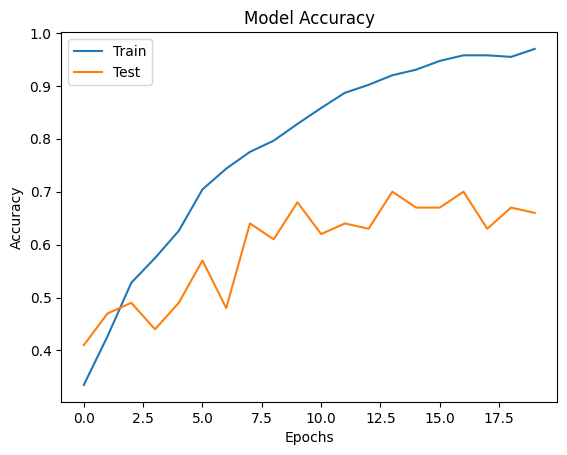

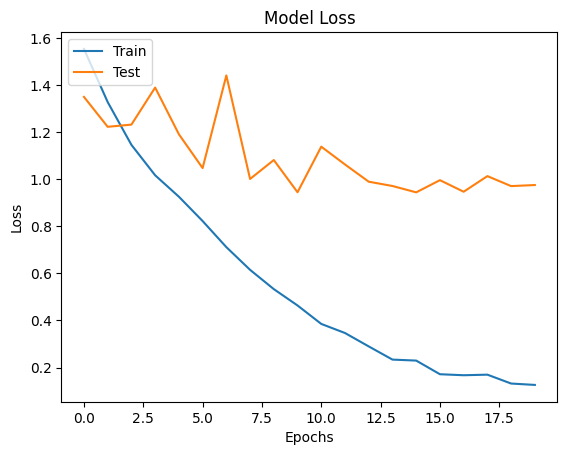

False


In [52]:
# Plot the training/validation accuracies/losses
plot(cnn_rnn_1_model.history, cnn_rnn_1)
# Save the model summary
save_summary(cnn_rnn_1, cnn_rnn_1_model, history_model23)

In [53]:
# Experimenting with CNN + GRU with data augmentation
# Model 24, frames_to_sample=20, batch_size=64, num_epochs=20, image_height=120, image_width=120
# filters=[8,16,32], cells=[64], dense_neurons=[64], dropout=[0.25,0.25]
cnn_rnn_2 = Model_CNN_RNN_1()
cnn_rnn_2.initialize_path(project_folder)
cnn_rnn_2.initialize_image_properties(image_height=120,image_width=120)
cnn_rnn_2.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=20)
cnn_rnn_2_model=cnn_rnn_2.define_model("cnn_rnn_2", filters=[8,16,32], cells=[64], dense_neurons=[64], dropout=[0.25,0.25])
print("Total Params:", cnn_rnn_2_model.count_params())
cnn_rnn_2_model.summary()


Total Params: 1405813


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_39             │ (None, 20, 120, 120,   │           224 │
│ (TimeDistributed)               │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_40             │ (None, 20, 120, 120,   │             0 │
│ (TimeDistributed)               │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_41             │ (None, 20, 120, 120,   │            32 │
│ (TimeDistributed)               │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_42             │ (None, 20, 60, 60, 8)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_43             │ (None, 20, 60, 60, 16) │         1,168 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_44             │ (None, 20, 60, 60, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_45             │ (None, 20, 60, 60, 16) │            64 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_46             │ (None, 20, 30, 30, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_47             │ (None, 20, 30, 30, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_48             │ (None, 20, 30, 30, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_49             │ (None, 20, 30, 30, 32) │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_50             │ (None, 20, 15, 15, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_51             │ (None, 20, 7200)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 64)             │     1,395,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 1,405,813 (5.36 MB)

 Trainable params: 1,405,701 (5.36 MB)

 Non-trainable params: 112 (448.00 B)

In [54]:
# Show the total number of parameters and start the training
print("Total Params:", cnn_rnn_2_model.count_params())
history_model24=cnn_rnn_2.train_model(cnn_rnn_2_model, augment_data=True)

Total Params: 1405813
Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.3257 - loss: 1.6105
Epoch 1: val_loss improved from inf to 1.39486, saving model to model/cnn_rnn_2_2024-04-1618_43_54.365234/model-00001-1.49697-0.36124-1.39486-0.37000.h5.keras

Epoch 1: val_loss improved from inf to 1.39486, saving model to model/cnn_rnn_2_2024-04-1618_43_54.365234/model-00001-1.49697-0.36124-1.39486-0.37000.h5.weights.h5
34/34 ━━━━━━━━━━━━━━━━━━━━ 116s 3s/step - categorical_accuracy: 0.3267 - loss: 1.6073 - val_categorical_accuracy: 0.3700 - val_loss: 1.3949 - learning_rate: 0.0100
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.4583 - loss: 1.2204
Epoch 2: val_loss improved from 1.39486 to 1.17935, saving model to model/cnn_rnn_2_2024-04-1618_43_54.365234/model-00002-1.21195-0.46229-1.17935-0.53000.h5.keras

Epoch 2: val_loss improved from 1.39486 to 1.17935, saving model to model/cnn_rnn_2_2024-04-1618_43_54.365234/model-00002-1.21195-0.4622

dict_keys(['categorical_accuracy', 'loss', 'val_categorical_accuracy', 'val_loss', 'learning_rate'])
0.3612368106842041 0.3700000047683716 1.4969661235809326 1.3948580026626587
0.8733031749725342 0.3492070734500885 0.7599999904632568 0.7284577488899231 19


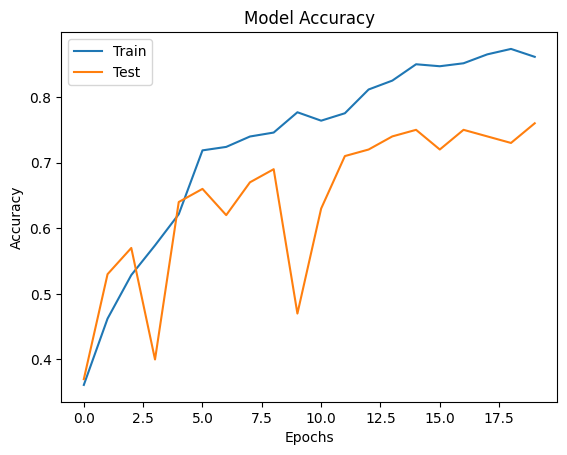

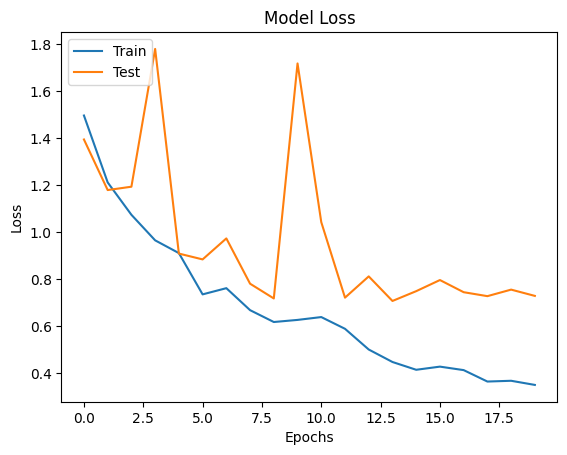

False


In [55]:
# Plot the training/validation accuracies/losses
plot(cnn_rnn_2_model.history, cnn_rnn_2)
# Save the model summary
save_summary(cnn_rnn_2, cnn_rnn_2_model, history_model24)

In [15]:
# Sample CNN-GRU Model with Adam optimizer

class Model_CNN_RNN_2(ModelBuilder_3):
    def define_model(self, name="cnn_rnn_1", filters=[16,32,64], cells=[64], dense_neurons=[64], dropout=[0.25,0.25]):
        self.name = name
        with tf.device('/device:GPU:0'):
            model= Sequential()

            model.add(TimeDistributed(Conv2D(filters[0], kernel_size=(3, 3),  padding='same'),input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
            model.add(TimeDistributed(Activation('relu')))
            model.add(TimeDistributed(BatchNormalization()))


            model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

            model.add(TimeDistributed(Conv2D(filters[1], kernel_size=(3, 3), padding='same')))
            model.add(TimeDistributed(Activation('relu')))
            model.add(TimeDistributed(BatchNormalization()))


            model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

            model.add(TimeDistributed(Conv2D(filters[2], kernel_size=(3, 3),  padding='same')))
            model.add(TimeDistributed(Activation('relu')))
            model.add(TimeDistributed(BatchNormalization()))


            model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

            model.add(TimeDistributed(Flatten()))

            model.add(GRU(cells[0]))
            model.add(Dropout(dropout[0]))

            model.add(Dense(dense_neurons[0], activation='relu'))
            model.add(Dropout(dropout[0]))

            model.add(Dense(self.num_classes, activation='softmax'))


            optimiser = optimizers.Adam()
            model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

        return model



In [57]:
# Experimenting with CNN + GRU (optimizer: Adam) with data augmentation
# Model 25, frames_to_sample=20, batch_size=64, num_epochs=20, image_height=120, image_width=120
# filters=[8,16,32], cells=[64], dense_neurons=[64], dropout=[0.25,0.25]
cnn_rnn_3 = Model_CNN_RNN_2()
cnn_rnn_3.initialize_path(project_folder)
cnn_rnn_3.initialize_image_properties(image_height=120,image_width=120)
cnn_rnn_3.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=20)
cnn_rnn_3_model=cnn_rnn_3.define_model("cnn_rnn_3", filters=[8,16,32], cells=[64], dense_neurons=[64], dropout=[0.25,0.25])
print("Total Params:", cnn_rnn_3_model.count_params())
cnn_rnn_3_model.summary()

Total Params: 1405813


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_52             │ (None, 20, 120, 120,   │           224 │
│ (TimeDistributed)               │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_53             │ (None, 20, 120, 120,   │             0 │
│ (TimeDistributed)               │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_54             │ (None, 20, 120, 120,   │            32 │
│ (TimeDistributed)               │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_55             │ (None, 20, 60, 60, 8)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_56             │ (None, 20, 60, 60, 16) │         1,168 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_57             │ (None, 20, 60, 60, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_58             │ (None, 20, 60, 60, 16) │            64 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_59             │ (None, 20, 30, 30, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_60             │ (None, 20, 30, 30, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_61             │ (None, 20, 30, 30, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_62             │ (None, 20, 30, 30, 32) │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_63             │ (None, 20, 15, 15, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_64             │ (None, 20, 7200)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ (None, 64)             │     1,395,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 1,405,813 (5.36 MB)

 Trainable params: 1,405,701 (5.36 MB)

 Non-trainable params: 112 (448.00 B)

In [58]:
# Show the total number of parameters and start the training
print("Total Params:", cnn_rnn_3_model.count_params())
history_model25=cnn_rnn_3.train_model(cnn_rnn_3_model, augment_data=True)

Total Params: 1405813
Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.2829 - loss: 1.6633
Epoch 1: val_loss improved from inf to 1.22615, saving model to model/cnn_rnn_3_2024-04-1619_16_52.363380/model-00001-1.58270-0.31825-1.22615-0.55000.h5.keras

Epoch 1: val_loss improved from inf to 1.22615, saving model to model/cnn_rnn_3_2024-04-1619_16_52.363380/model-00001-1.58270-0.31825-1.22615-0.55000.h5.weights.h5
34/34 ━━━━━━━━━━━━━━━━━━━━ 107s 3s/step - categorical_accuracy: 0.2839 - loss: 1.6610 - val_categorical_accuracy: 0.5500 - val_loss: 1.2262 - learning_rate: 0.0010
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.4374 - loss: 1.3554
Epoch 2: val_loss improved from 1.22615 to 1.07648, saving model to model/cnn_rnn_3_2024-04-1619_16_52.363380/model-00002-1.32954-0.45249-1.07648-0.63000.h5.keras

Epoch 2: val_loss improved from 1.22615 to 1.07648, saving model to model/cnn_rnn_3_2024-04-1619_16_52.363380/model-00002-1.32954-0.4524

dict_keys(['categorical_accuracy', 'loss', 'val_categorical_accuracy', 'val_loss', 'learning_rate'])
0.3182503879070282 0.550000011920929 1.5827009677886963 1.2261502742767334
0.849170446395874 0.4818531572818756 0.75 0.7386167049407959 14


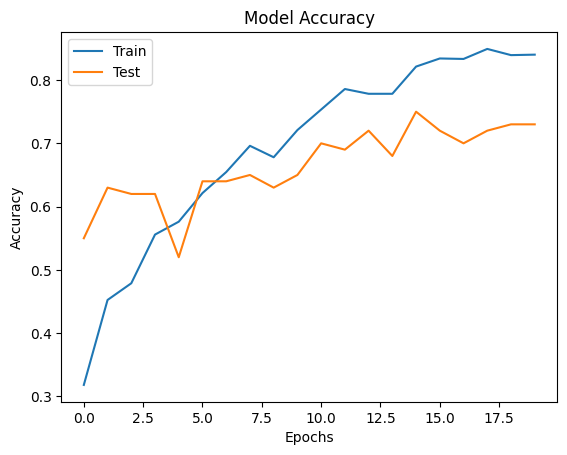

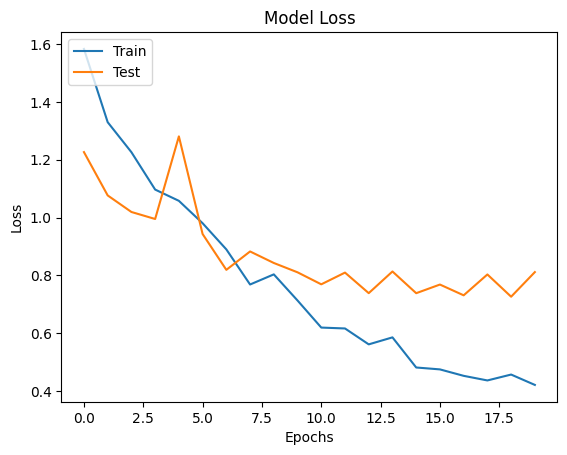

False


In [59]:
# Plot the training/validation accuracies/losses
plot(cnn_rnn_3_model.history, cnn_rnn_3)
# Save the model summary
save_summary(cnn_rnn_3, cnn_rnn_3_model, history_model25)

In [21]:
# Sample CNN-GRU Model with Adam optimizer (5 hidden layers)

class Model_CNN_RNN_3(ModelBuilder_3):
    def define_model(self, name="cnn_rnn_1", filters=[16,32,64,128,256], cells=[64], dense_neurons=[64], dropout=[0.25,0.25]):
        self.name = name
        with tf.device('/device:GPU:0'):
            model= Sequential()

            model.add(TimeDistributed(Conv2D(filters[0], kernel_size=(3, 3),  padding='same'),input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
            model.add(TimeDistributed(Activation('relu')))
            model.add(TimeDistributed(BatchNormalization()))


            model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

            model.add(TimeDistributed(Conv2D(filters[1], kernel_size=(3, 3), padding='same')))
            model.add(TimeDistributed(Activation('relu')))
            model.add(TimeDistributed(BatchNormalization()))


            model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

            model.add(TimeDistributed(Conv2D(filters[2], kernel_size=(3, 3),  padding='same')))
            model.add(TimeDistributed(Activation('relu')))
            model.add(TimeDistributed(BatchNormalization()))


            model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

            model.add(TimeDistributed(Conv2D(filters[3], kernel_size=(3, 3),  padding='same')))
            model.add(TimeDistributed(Activation('relu')))
            model.add(TimeDistributed(BatchNormalization()))


            model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

            model.add(TimeDistributed(Conv2D(filters[4], kernel_size=(3, 3),  padding='same')))
            model.add(TimeDistributed(Activation('relu')))
            model.add(TimeDistributed(BatchNormalization()))


            model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

            model.add(TimeDistributed(Flatten()))

            model.add(GRU(cells[0]))
            model.add(Dropout(dropout[0]))

            model.add(Dense(dense_neurons[0], activation='relu'))
            model.add(Dropout(dropout[0]))

            model.add(Dense(self.num_classes, activation='softmax'))


            optimiser = optimizers.Adam()
            model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

        return model



In [22]:
# Experimenting with CNN + GRU (optimizer: Adam) with data augmentation (Gray: ModelBuilder) and 5 hidden layers
# Model 26, frames_to_sample=20, batch_size=20, num_epochs=20, image_height=120, image_width=120
# filters=[16,32,64,128,256], cells=[128], dense_neurons=[64], dropout=[0.25,0.25]
cnn_rnn_4 = Model_CNN_RNN_3()
cnn_rnn_4.initialize_path(project_folder)
cnn_rnn_4.initialize_image_properties(image_height=120,image_width=120)
cnn_rnn_4.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=20)
cnn_rnn_4_model=cnn_rnn_4.define_model("cnn_rnn_4", filters=[8,16,32,64,128], cells=[64], dense_neurons=[64], dropout=[0.25,0.25])
print("Total Params:", cnn_rnn_4_model.count_params())
cnn_rnn_4_model.summary()

Total Params: 337717


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_26             │ (None, 20, 120, 120,   │           224 │
│ (TimeDistributed)               │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_27             │ (None, 20, 120, 120,   │             0 │
│ (TimeDistributed)               │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_28             │ (None, 20, 120, 120,   │            32 │
│ (TimeDistributed)               │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_29             │ (None, 20, 60, 60, 8)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_30             │ (None, 20, 60, 60, 16) │         1,168 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_31             │ (None, 20, 60, 60, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_32             │ (None, 20, 60, 60, 16) │            64 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_33             │ (None, 20, 30, 30, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_34             │ (None, 20, 30, 30, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_35             │ (None, 20, 30, 30, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_36             │ (None, 20, 30, 30, 32) │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_37             │ (None, 20, 15, 15, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_38             │ (None, 20, 15, 15, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_39             │ (None, 20, 15, 15, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_40             │ (None, 20, 15, 15, 64) │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_41             │ (None, 20, 7, 7, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_42             │ (None, 20, 7, 7, 128)  │        73,85

 Total params: 337,717 (1.29 MB)

 Trainable params: 337,221 (1.29 MB)

 Non-trainable params: 496 (1.94 KB)

In [23]:
# Show the total number of parameters and start the training
print("Total Params:", cnn_rnn_4_model.count_params())
history_model26=cnn_rnn_4.train_model(cnn_rnn_4_model, augment_data=True)

Total Params: 337717
Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.3278 - loss: 1.6218
Epoch 1: val_loss improved from inf to 1.21639, saving model to model/cnn_rnn_4_2024-04-1621_01_24.977495/model-00001-1.50105-0.36425-1.21639-0.63000.h5.keras

Epoch 1: val_loss improved from inf to 1.21639, saving model to model/cnn_rnn_4_2024-04-1621_01_24.977495/model-00001-1.50105-0.36425-1.21639-0.63000.h5.weights.h5
34/34 ━━━━━━━━━━━━━━━━━━━━ 120s 3s/step - categorical_accuracy: 0.3288 - loss: 1.6184 - val_categorical_accuracy: 0.6300 - val_loss: 1.2164 - learning_rate: 0.0010
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.4605 - loss: 1.2840
Epoch 2: val_loss improved from 1.21639 to 0.96884, saving model to model/cnn_rnn_4_2024-04-1621_01_24.977495/model-00002-1.22963-0.49698-0.96884-0.62000.h5.keras

Epoch 2: val_loss improved from 1.21639 to 0.96884, saving model to model/cnn_rnn_4_2024-04-1621_01_24.977495/model-00002-1.22963-0.49698

dict_keys(['categorical_accuracy', 'loss', 'val_categorical_accuracy', 'val_loss', 'learning_rate'])
0.3642534017562866 0.6299999952316284 1.501053810119629 1.2163889408111572
0.9487179517745972 0.22635552287101746 0.8399999737739563 0.5096191167831421 14


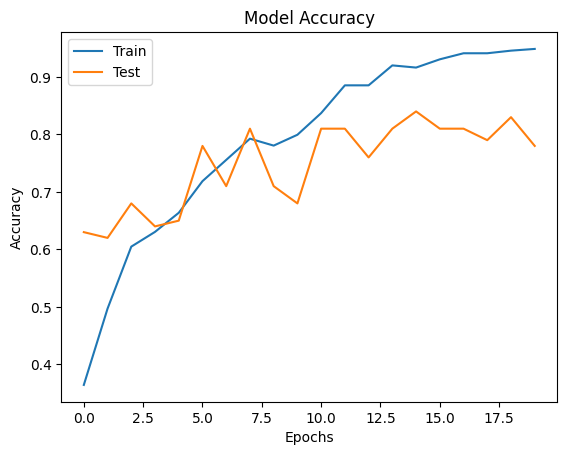

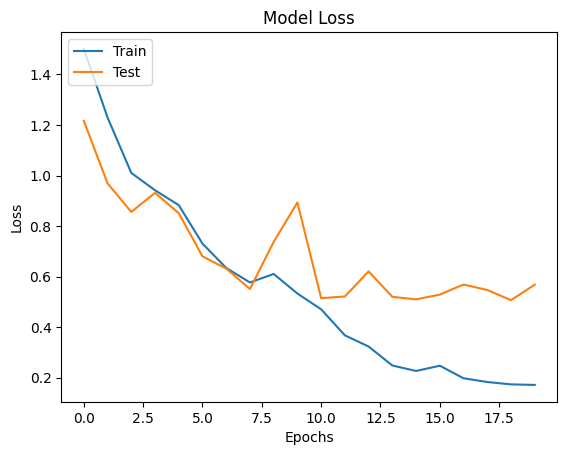

False


In [24]:
# Plot the training/validation accuracies/losses
plot(cnn_rnn_4_model.history, cnn_rnn_4)
# Save the model summary
save_summary(cnn_rnn_4, cnn_rnn_4_model, history_model26)

##### CNN + LSTM

In [25]:
# Sample CNN-LSTM Model with Adam optimizer (5 hidden layers)

class Model_CNN_LSTM_1(ModelBuilder_3):
    def define_model(self, name="cnn_lstm_1", filters=[16,32,64,128,256], cells=[64], dense_neurons=[64], dropout=[0.25,0.25]):
        self.name = name
        with tf.device('/device:GPU:0'):
            model= Sequential()

            model.add(TimeDistributed(Conv2D(filters[0], kernel_size=(3, 3),  padding='same'),input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
            model.add(TimeDistributed(Activation('relu')))
            model.add(TimeDistributed(BatchNormalization()))


            model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

            model.add(TimeDistributed(Conv2D(filters[1], kernel_size=(3, 3), padding='same')))
            model.add(TimeDistributed(Activation('relu')))
            model.add(TimeDistributed(BatchNormalization()))


            model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

            model.add(TimeDistributed(Conv2D(filters[2], kernel_size=(3, 3),  padding='same')))
            model.add(TimeDistributed(Activation('relu')))
            model.add(TimeDistributed(BatchNormalization()))


            model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

            model.add(TimeDistributed(Conv2D(filters[3], kernel_size=(3, 3),  padding='same')))
            model.add(TimeDistributed(Activation('relu')))
            model.add(TimeDistributed(BatchNormalization()))


            model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

            model.add(TimeDistributed(Conv2D(filters[4], kernel_size=(3, 3),  padding='same')))
            model.add(TimeDistributed(Activation('relu')))
            model.add(TimeDistributed(BatchNormalization()))


            model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

            model.add(TimeDistributed(Flatten()))

            model.add(LSTM(cells[0]))
            model.add(Dropout(dropout[0]))

            model.add(Dense(dense_neurons[0], activation='relu'))
            model.add(Dropout(dropout[0]))

            model.add(Dense(self.num_classes, activation='softmax'))


            optimiser = optimizers.Adam()
            model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

        return model



In [30]:
# Experimenting with CNN + LSTM (optimizer: Adam) with data augmentation and 5 hidden layers
# Model 27, frames_to_sample=20, batch_size=64, num_epochs=20, image_height=120, image_width=120
# filters=[16,32,64,128,256], cells=[64], dense_neurons=[64], dropout=[0.25,0.25]
cnn_lstm_1 = Model_CNN_LSTM_1()
cnn_lstm_1.initialize_path(project_folder)
cnn_lstm_1.initialize_image_properties(image_height=120,image_width=120)
cnn_lstm_1.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=20)
cnn_lstm_1_model=cnn_lstm_1.define_model("cnn_lstm_1", filters=[8,16,32,64,128], cells=[64], dense_neurons=[64], dropout=[0.25,0.25])
print("Total Params:", cnn_lstm_1_model.count_params())
cnn_lstm_1_model.summary()

Total Params: 415413


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_89             │ (None, 20, 120, 120,   │           224 │
│ (TimeDistributed)               │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_90             │ (None, 20, 120, 120,   │             0 │
│ (TimeDistributed)               │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_91             │ (None, 20, 120, 120,   │            32 │
│ (TimeDistributed)               │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_92             │ (None, 20, 60, 60, 8)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_93             │ (None, 20, 60, 60, 16) │         1,168 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_94             │ (None, 20, 60, 60, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_95             │ (None, 20, 60, 60, 16) │            64 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_96             │ (None, 20, 30, 30, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_97             │ (None, 20, 30, 30, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_98             │ (None, 20, 30, 30, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_99             │ (None, 20, 30, 30, 32) │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_100            │ (None, 20, 15, 15, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_101            │ (None, 20, 15, 15, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_102            │ (None, 20, 15, 15, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_103            │ (None, 20, 15, 15, 64) │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_104            │ (None, 20, 7, 7, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_105            │ (None, 20, 7, 7, 128)  │        73,85

 Total params: 415,413 (1.58 MB)

 Trainable params: 414,917 (1.58 MB)

 Non-trainable params: 496 (1.94 KB)

In [31]:
# Show the total number of parameters and start the training
print("Total Params:", cnn_lstm_1_model.count_params())
history_model27=cnn_lstm_1.train_model(cnn_lstm_1_model, augment_data=True)

Total Params: 415413
Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.2629 - loss: 1.6152
Epoch 1: val_loss improved from inf to 1.28889, saving model to model/cnn_lstm_1_2024-04-1621_54_10.051349/model-00001-1.53975-0.31222-1.28889-0.57000.h5.keras

Epoch 1: val_loss improved from inf to 1.28889, saving model to model/cnn_lstm_1_2024-04-1621_54_10.051349/model-00001-1.53975-0.31222-1.28889-0.57000.h5.weights.h5
34/34 ━━━━━━━━━━━━━━━━━━━━ 120s 3s/step - categorical_accuracy: 0.2643 - loss: 1.6131 - val_categorical_accuracy: 0.5700 - val_loss: 1.2889 - learning_rate: 0.0010
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.4705 - loss: 1.2670
Epoch 2: val_loss improved from 1.28889 to 1.11765, saving model to model/cnn_lstm_1_2024-04-1621_54_10.051349/model-00002-1.28876-0.44495-1.11765-0.63000.h5.keras

Epoch 2: val_loss improved from 1.28889 to 1.11765, saving model to model/cnn_lstm_1_2024-04-1621_54_10.051349/model-00002-1.28876-0.4

dict_keys(['categorical_accuracy', 'loss', 'val_categorical_accuracy', 'val_loss', 'learning_rate'])
0.31221720576286316 0.5699999928474426 1.5397462844848633 1.288894534111023
0.8785821795463562 0.7214341163635254 0.7599999904632568 0.6287482380867004 11


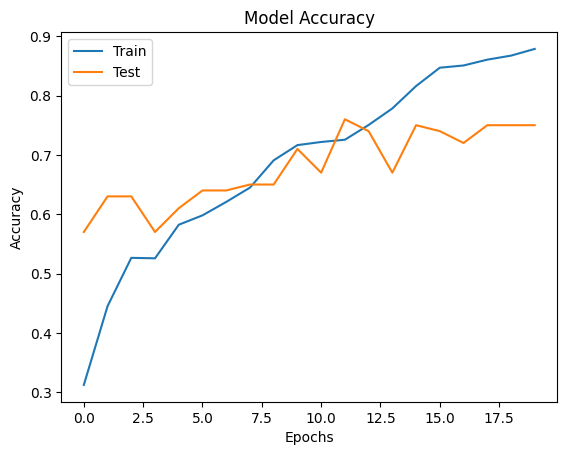

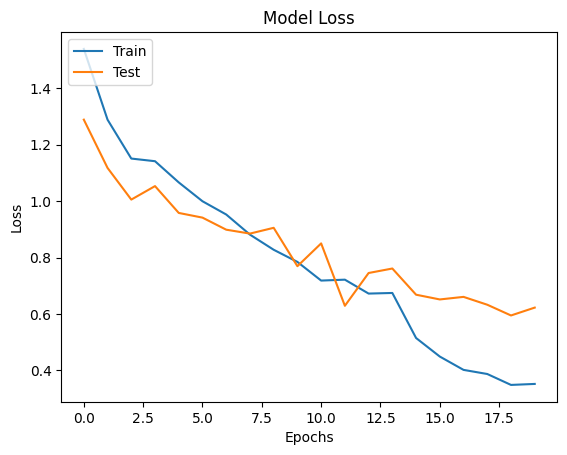

False


In [32]:
# Plot the training/validation accuracies/losses
plot(cnn_lstm_1_model.history, cnn_lstm_1)
# Save the model summary    
save_summary(cnn_lstm_1, cnn_lstm_1_model, history_model27)

In [10]:
# ## Generator
# This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

class ModelBuilder_4(metaclass= abc.ABCMeta):
    # initialisng the path where project data resides
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
    # initialising the image properties    
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
        

    # initialising the batch size, frames to sample and the no. of epochs
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
    # MOST IMPORTANT PART HERE - The generator function        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
   
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx):
                #performing image reading and resizing
                image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                #image_resized=imresize(image,(self.image_height,self.image_width,3))
                image_resized = crop_resize_img(image,self.image_width,self.image_height)
                # image_resized = cv2.resize(image, (self.image_width,self.image_height), interpolation = cv2.INTER_AREA)

                #normalizing the images
                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    # cropping the images to have the targeted gestures and remove the noise from the images.
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    # image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    image_resized = crop_resize_img(cropped, self.image_width, self.image_height)
                    # image_resized = cv2.resize(cropped, (self.image_width,self.image_height), interpolation = cv2.INTER_AREA)

                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        start_time = time.perf_counter()
                
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        if not os.path.exists('model'):
            os.mkdir('model')

        model_name = 'model/' + self.name + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
        self.filepath = filepath

        checkpoint = ModelCheckpoint(filepath + '.keras', monitor='val_loss', verbose=1, save_freq='epoch', save_best_only=True, save_weights_only=False, mode='auto')
        checkpoint_h5 = ModelCheckpoint(filepath + '.weights.h5', monitor='val_loss', verbose=1, save_freq='epoch', save_best_only=True, save_weights_only=True, mode='auto')
        
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)
        earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
        
        logdir = "logs/scalars/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = TensorBoard(log_dir=logdir)
        csv_logger = CSVLogger(f'{filepath}.log')

        callbacks_list = [checkpoint, checkpoint_h5, LR, earlystop, tensorboard_callback, csv_logger]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        # history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
        #                     callbacks=callbacks_list, validation_data=val_generator, 
        #                     validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, initial_epoch=0)
        end_time = time.perf_counter()
        self.total_time = end_time - start_time
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass
    
    

In [11]:
# Sample CNN-LSTM Model with Adam optimizer (5 hidden layers), put relu inside Conv2D

class Model_CNN_LSTM_2(ModelBuilder_4):
    def define_model(self, name="cnn_lstm_1", filters=[16,32,64,128,256], lstm_cells=[64], dense_neurons=[64], dropout=[0.25,0.25]):
        self.name = name
    
        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        #model.add(TimeDistributed(Conv2D(512, (2, 2) , padding='valid', activation='relu')))
       # model.add(TimeDistributed(BatchNormalization()))
       # model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [12]:
# Experimenting with CNN + LSTM (optimizer: Adam) with data augmentation and 5 hidden layers, put relu inside Conv2D
# Model 28, frames_to_sample=20, batch_size=64, num_epochs=20, image_height=120, image_width=120
# filters=[16,32,64,128,256], cells=[64], dense_neurons=[64], dropout=[0.25,0.25]
cnn_lstm_2 = Model_CNN_LSTM_2()
cnn_lstm_2.initialize_path(project_folder)
cnn_lstm_2.initialize_image_properties(image_height=120,image_width=120)
cnn_lstm_2.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
cnn_lstm_2_model=cnn_lstm_2.define_model("cnn_lstm_2", filters=[16,32,64,128,256], lstm_cells=64, dense_neurons=64, dropout=0.25)
print("Total Params:", cnn_lstm_2_model.count_params())
cnn_lstm_2_model.summary()

2024-04-16 23:15:10.876081: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 23:15:10.954453: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 23:15:10.956614: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Total Params: 1005541


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 18, 120, 120,   │           448 │
│ (TimeDistributed)               │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 18, 120, 120,   │            64 │
│ (TimeDistributed)               │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 18, 60, 60, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 18, 60, 60, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 18, 60, 60, 32) │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 18, 30, 30, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 18, 30, 30, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 18, 30, 30, 64) │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 18, 15, 15, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 18, 15, 15,     │        73,856 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 18, 15, 15,     │           512 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 18, 7, 7, 128)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_12             │ (None, 18, 7, 7, 256)  │       295,168 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_13             │ (None, 18, 7, 7, 256)  │         1,024 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_14             │ (None, 18, 3, 3, 256)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_15             │ (None, 18, 2304)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │       606,46

 Total params: 1,005,541 (3.84 MB)

 Trainable params: 1,004,549 (3.83 MB)

 Non-trainable params: 992 (3.88 KB)

In [13]:
# Show the total number of parameters and start the training
print("Total Params:", cnn_lstm_2_model.count_params())
history_model28=cnn_lstm_2.train_model(cnn_lstm_2_model, augment_data=True)

Total Params: 1005541
Epoch 1/20


2024-04-16 23:15:39.629076: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.3025 - loss: 1.5702
Epoch 1: val_loss improved from inf to 1.23675, saving model to model/cnn_lstm_2_2024-04-1623_15_21.636535/model-00001-1.51177-0.33484-1.23675-0.44000.h5.keras

Epoch 1: val_loss improved from inf to 1.23675, saving model to model/cnn_lstm_2_2024-04-1623_15_21.636535/model-00001-1.51177-0.33484-1.23675-0.44000.h5.weights.h5
34/34 ━━━━━━━━━━━━━━━━━━━━ 102s 3s/step - categorical_accuracy: 0.3034 - loss: 1.5685 - val_categorical_accuracy: 0.4400 - val_loss: 1.2368 - learning_rate: 0.0010
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.4261 - loss: 1.3354
Epoch 2: val_loss improved from 1.23675 to 1.15884, saving model to model/cnn_lstm_2_2024-04-1623_15_21.636535/model-00002-1.28363-0.45626-1.15884-0.51000.h5.keras

Epoch 2: val_loss improved from 1.23675 to 1.15884, saving model to model/cnn_lstm_2_2024-04-1623_15_21.636535/model-00002-1.28363-0.45626-1.15884-0.51000.h5.weights.

dict_keys(['categorical_accuracy', 'loss', 'val_categorical_accuracy', 'val_loss', 'learning_rate'])
0.33484163880348206 0.4399999976158142 1.5117741823196411 1.2367527484893799
0.814479649066925 0.6477888226509094 0.800000011920929 0.5760327577590942 17


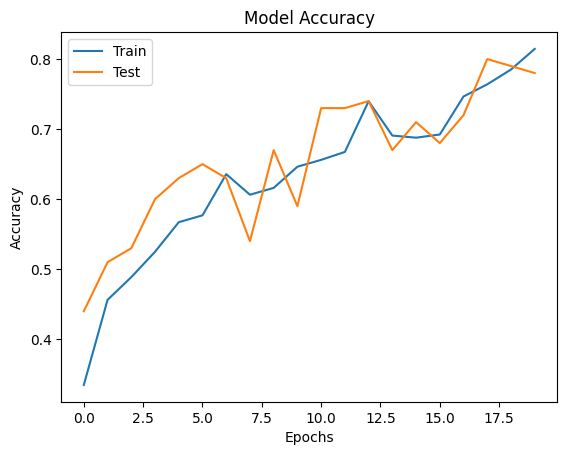

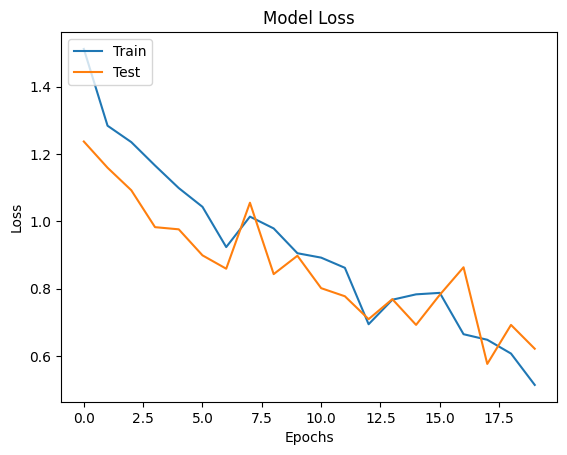

False


In [14]:
# Plot the training/validation accuracies/losses
plot(cnn_lstm_2_model.history, cnn_lstm_2)
# Save the model summary
save_summary(cnn_lstm_2, cnn_lstm_2_model, history_model28)

In [20]:
# Experimenting with CNN + LSTM (optimizer: Adam) with data augmentation and 5 hidden layers, put relu inside Conv2D
# Model 30, frames_to_sample=16, batch_size=5, num_epochs=20, image_height=120, image_width=120
# filters=[16,32,64,128,256], cells=[64], dense_neurons=[64], dropout=[0.25,0.25]
cnn_lstm_3 = Model_CNN_LSTM_2()
cnn_lstm_3.initialize_path(project_folder)
cnn_lstm_3.initialize_image_properties(image_height=120,image_width=120)
cnn_lstm_3.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
cnn_lstm_3_model=cnn_lstm_3.define_model("cnn_lstm_3", filters=[16,32,64,128,256], lstm_cells=64, dense_neurons=64, dropout=0.25)
print("Total Params:", cnn_lstm_3_model.count_params())
cnn_lstm_3_model.summary()

Total Params: 1005541


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_20             │ (None, 16, 120, 120,   │           448 │
│ (TimeDistributed)               │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_21             │ (None, 16, 120, 120,   │            64 │
│ (TimeDistributed)               │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_22             │ (None, 16, 60, 60, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_23             │ (None, 16, 60, 60, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_24             │ (None, 16, 60, 60, 32) │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_25             │ (None, 16, 30, 30, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_26             │ (None, 16, 30, 30, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_27             │ (None, 16, 30, 30, 64) │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_28             │ (None, 16, 15, 15, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_29             │ (None, 16, 15, 15,     │        73,856 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_30             │ (None, 16, 15, 15,     │           512 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_31             │ (None, 16, 7, 7, 128)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_32             │ (None, 16, 7, 7, 256)  │       295,168 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_33             │ (None, 16, 7, 7, 256)  │         1,024 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_34             │ (None, 16, 3, 3, 256)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_35             │ (None, 16, 2304)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │       606,46

 Total params: 1,005,541 (3.84 MB)

 Trainable params: 1,004,549 (3.83 MB)

 Non-trainable params: 992 (3.88 KB)

In [21]:
# Show the total number of parameters and start the training
print("Total Params:", cnn_lstm_3_model.count_params())
history_model30=cnn_lstm_3.train_model(cnn_lstm_3_model, augment_data=True)

Total Params: 1005541
Epoch 1/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - categorical_accuracy: 0.2539 - loss: 1.6365
Epoch 1: val_loss improved from inf to 1.37379, saving model to model/cnn_lstm_3_2024-04-1700_15_05.953899/model-00001-1.56497-0.29789-1.37379-0.45000.h5.keras

Epoch 1: val_loss improved from inf to 1.37379, saving model to model/cnn_lstm_3_2024-04-1700_15_05.953899/model-00001-1.56497-0.29789-1.37379-0.45000.h5.weights.h5
133/133 ━━━━━━━━━━━━━━━━━━━━ 96s 639ms/step - categorical_accuracy: 0.2542 - loss: 1.6359 - val_categorical_accuracy: 0.4500 - val_loss: 1.3738 - learning_rate: 0.0010
Epoch 2/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 548ms/step - categorical_accuracy: 0.3550 - loss: 1.4712
Epoch 2: val_loss improved from 1.37379 to 1.29950, saving model to model/cnn_lstm_3_2024-04-1700_15_05.953899/model-00002-1.46896-0.35897-1.29950-0.47000.h5.keras

Epoch 2: val_loss improved from 1.37379 to 1.29950, saving model to model/cnn_lstm_3_2024-04-1700_15_05.953899/model-00

dict_keys(['categorical_accuracy', 'loss', 'val_categorical_accuracy', 'val_loss', 'learning_rate'])
0.2978883981704712 0.44999998807907104 1.564965009689331 1.3737887144088745
0.7088989615440369 0.736510694026947 0.7900000214576721 0.6315469145774841 19


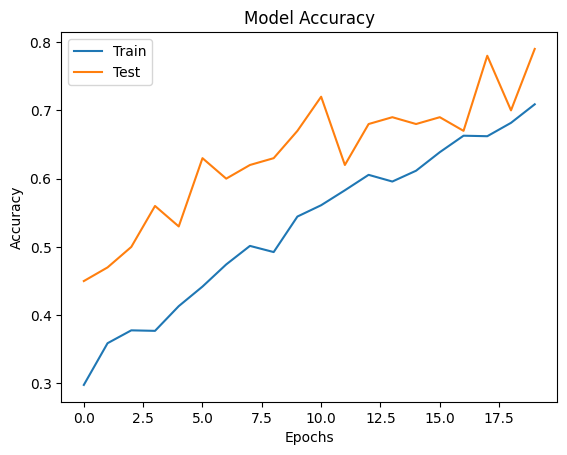

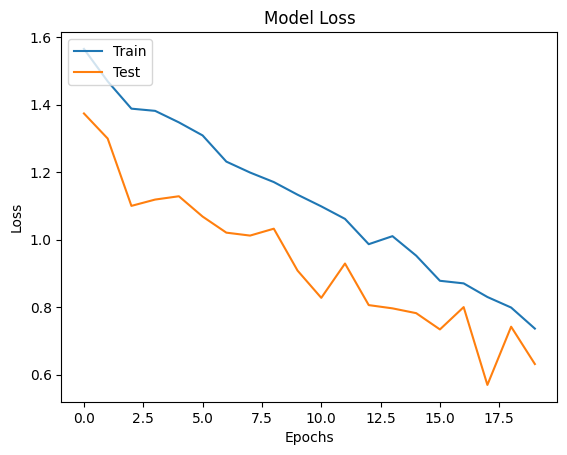

False


In [22]:
# Plot the training/validation accuracies/losses
plot(cnn_lstm_3_model.history, cnn_lstm_3)
# Save the model summary
save_summary(cnn_lstm_3, cnn_lstm_3_model, history_model30)

In [23]:
# Experimenting with CNN + LSTM (optimizer: Adam) with data augmentation and 5 hidden layers, put relu inside Conv2D
# Model 31, frames_to_sample=16, batch_size=5, num_epochs=20, image_height=120, image_width=120
# filters=[16,32,64,128,256], lstm_cells=[128], dense_neurons=[128], dropout=[0.25,0.25]
cnn_lstm_4 = Model_CNN_LSTM_2()
cnn_lstm_4.initialize_path(project_folder)
cnn_lstm_4.initialize_image_properties(image_height=120,image_width=120)
cnn_lstm_4.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
cnn_lstm_4_model=cnn_lstm_4.define_model("cnn_lstm_4", filters=[16,32,64,128,256], lstm_cells=128, dense_neurons=128, dropout=0.25)
print("Total Params:", cnn_lstm_4_model.count_params())
cnn_lstm_4_model.summary()

Total Params: 1657445


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_36             │ (None, 16, 120, 120,   │           448 │
│ (TimeDistributed)               │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_37             │ (None, 16, 120, 120,   │            64 │
│ (TimeDistributed)               │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_38             │ (None, 16, 60, 60, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_39             │ (None, 16, 60, 60, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_40             │ (None, 16, 60, 60, 32) │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_41             │ (None, 16, 30, 30, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_42             │ (None, 16, 30, 30, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_43             │ (None, 16, 30, 30, 64) │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_44             │ (None, 16, 15, 15, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_45             │ (None, 16, 15, 15,     │        73,856 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_46             │ (None, 16, 15, 15,     │           512 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_47             │ (None, 16, 7, 7, 128)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_48             │ (None, 16, 7, 7, 256)  │       295,168 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_49             │ (None, 16, 7, 7, 256)  │         1,024 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_50             │ (None, 16, 3, 3, 256)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_51             │ (None, 16, 2304)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128)            │     1,245,69

 Total params: 1,657,445 (6.32 MB)

 Trainable params: 1,656,453 (6.32 MB)

 Non-trainable params: 992 (3.88 KB)

In [24]:
# Show the total number of parameters and start the training
print("Total Params:", cnn_lstm_4_model.count_params())
history_model31=cnn_lstm_4.train_model(cnn_lstm_4_model, augment_data=True)

Total Params: 1657445
Epoch 1/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 548ms/step - categorical_accuracy: 0.2769 - loss: 1.6294
Epoch 1: val_loss improved from inf to 1.21588, saving model to model/cnn_lstm_4_2024-04-1700_43_30.015980/model-00001-1.54306-0.32579-1.21588-0.50000.h5.keras

Epoch 1: val_loss improved from inf to 1.21588, saving model to model/cnn_lstm_4_2024-04-1700_43_30.015980/model-00001-1.54306-0.32579-1.21588-0.50000.h5.weights.h5
133/133 ━━━━━━━━━━━━━━━━━━━━ 94s 615ms/step - categorical_accuracy: 0.2773 - loss: 1.6288 - val_categorical_accuracy: 0.5000 - val_loss: 1.2159 - learning_rate: 0.0010
Epoch 2/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - categorical_accuracy: 0.4029 - loss: 1.3985
Epoch 2: val_loss did not improve from 1.21588

Epoch 2: val_loss did not improve from 1.21588
133/133 ━━━━━━━━━━━━━━━━━━━━ 79s 597ms/step - categorical_accuracy: 0.4028 - loss: 1.3986 - val_categorical_accuracy: 0.5200 - val_loss: 1.2284 - learning_rate: 0.0010
Epoch 3/20
133/133 ━━

dict_keys(['categorical_accuracy', 'loss', 'val_categorical_accuracy', 'val_loss', 'learning_rate'])
0.3257918655872345 0.5 1.5430560111999512 1.215879201889038
0.7911010384559631 0.5590915679931641 0.7900000214576721 0.6349190473556519 18


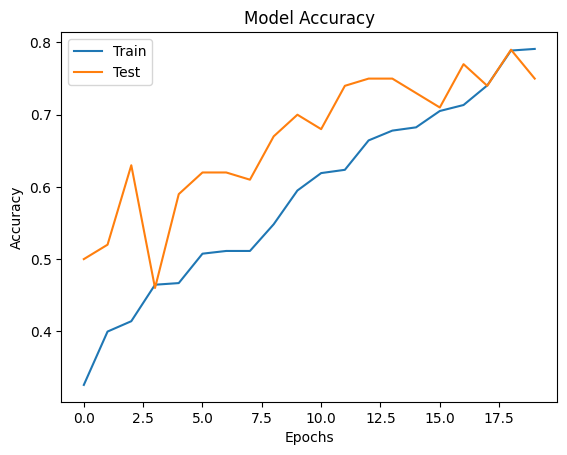

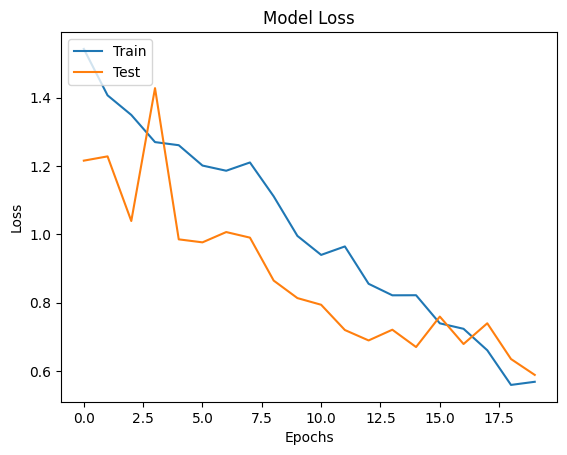

False


In [25]:
# Plot the training/validation accuracies/losses
plot(cnn_lstm_4_model.history, cnn_lstm_4)
# Save the model summary
save_summary(cnn_lstm_4, cnn_lstm_4_model, history_model31)

##### Transfer Learning

###### Mobilenet

In [15]:
# Import Mobilenet from Keras
from tensorflow.keras.applications import mobilenet

In [16]:


mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)


class RNNCNN_TL(ModelBuilder_4):
    
    def define_model(self, name="rnncnn_tl_1", lstm_cells=64, dense_neurons=64, dropout=0.25):
        self.name = name
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        
        
        # for layer in model.layers:
        #     layer.trainable = False
        
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model


In [17]:
# Experimenting with Transfer Learning (Mobilenet) with data augmentation
# Model 29, frames_to_sample=20, batch_size=64, num_epochs=20, image_height=120, image_width=120
# lstm_cells=128, dense_neurons=128, dropout=0.25
rnn_cnn_tl = RNNCNN_TL()
rnn_cnn_tl.initialize_path(project_folder)
rnn_cnn_tl.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=20)
rnn_cnn_tl_model=rnn_cnn_tl.define_model("rnn_cnn_tl_mobilenet",lstm_cells=128, dense_neurons=128, dropout=0.25)
print("Total Params:", rnn_cnn_tl_model.count_params())
rnn_cnn_tl_model.summary()

Total Params: 3228864


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_16             │ ?                      │     3,228,864 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_17             │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_18             │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_19             │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 3,206,976 (12.23 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [18]:
# Show the total number of parameters and start the training
print("Total Params:", rnn_cnn_tl_model.count_params())
history_model29=rnn_cnn_tl.train_model(rnn_cnn_tl_model, augment_data=True)

Total Params: 3228864
Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.3545 - loss: 1.4692
Epoch 1: val_loss improved from inf to 0.53454, saving model to model/rnn_cnn_tl_mobilenet_2024-04-1623_42_56.193577/model-00001-1.26660-0.47738-0.53454-0.81000.h5.keras

Epoch 1: val_loss improved from inf to 0.53454, saving model to model/rnn_cnn_tl_mobilenet_2024-04-1623_42_56.193577/model-00001-1.26660-0.47738-0.53454-0.81000.h5.weights.h5
34/34 ━━━━━━━━━━━━━━━━━━━━ 171s 3s/step - categorical_accuracy: 0.3581 - loss: 1.4634 - val_categorical_accuracy: 0.8100 - val_loss: 0.5345 - learning_rate: 0.0010
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.7235 - loss: 0.6931
Epoch 2: val_loss improved from 0.53454 to 0.32795, saving model to model/rnn_cnn_tl_mobilenet_2024-04-1623_42_56.193577/model-00002-0.65771-0.73379-0.32795-0.88000.h5.keras

Epoch 2: val_loss improved from 0.53454 to 0.32795, saving model to model/rnn_cnn_tl_mobilenet_2024-04-

dict_keys(['categorical_accuracy', 'loss', 'val_categorical_accuracy', 'val_loss', 'learning_rate'])
0.4773755669593811 0.8100000023841858 1.2665965557098389 0.5345442295074463
0.9826545715332031 0.12552955746650696 0.949999988079071 0.1599997729063034 12


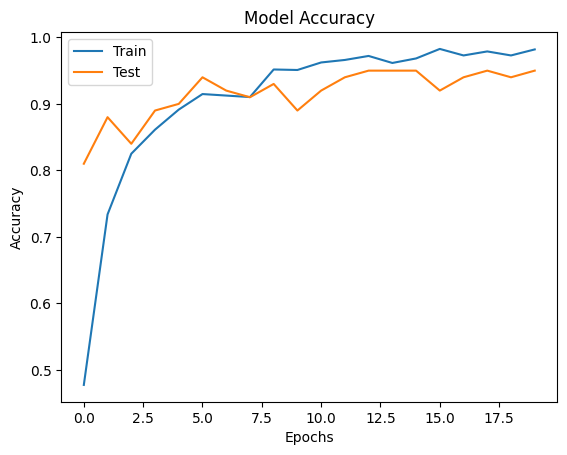

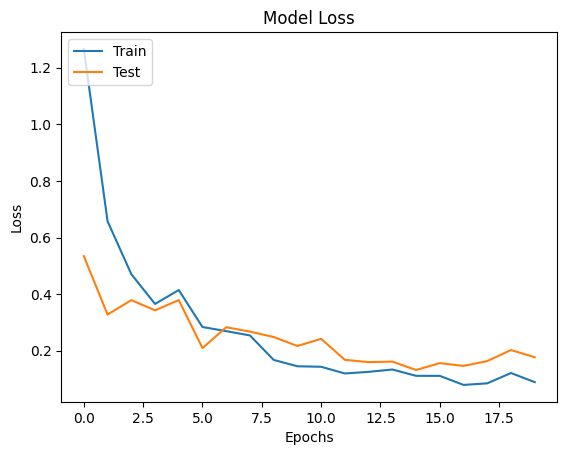

False


In [19]:
# Plot the training/validation accuracies/losses
plot(rnn_cnn_tl_model.history, rnn_cnn_tl)
# Save the model summary
save_summary(rnn_cnn_tl, rnn_cnn_tl_model, history_model29)

###### 